# Smart Forecasting System to Optimize Food Orders and Reduce Wastage in Hotels

#### This project helps hotels predict future food orders and reduce kitchen waste by analyzing historical data, holidays, and dish trends.

## PROJECT OBJECTIVE (What are we solving?)

In the hotel industry, unpredictable demand often leads to:

   - Excess food preparation → results in high food wastage
 
   - Insufficient stock or staff → causes poor customer experience

Our goal is to:

   - Forecast dish-level food demand for upcoming days/weeks

   - Identify high wastage periods and reduce overproduction

   - Use holiday & seasonal patterns to improve kitchen planning

   - Ultimately increase operational efficiency and customer satisfaction

### TARGET AUDIENCE

- Hotel Operations Manager

- Kitchen Planner

- Hotel HR/Decision Maker

## DATA SOURCES USED

- messy orders customer data.csv	- Main food order logs by dish and date
- Dish_Name_Ingredients.csv	        - Ingredients per dish (optional for cost/waste)
- Holiday_List.csv	                - List of holidays affecting demand
- food_wastage2022_dataset.csv	    - Wastage logs, tells us which months/days are waste-heavy

## BUSINESS QUESTIONS TO ANSWER

- What is the forecasted number of dishes needed in the upcoming weeks?

- Which dishes are in high demand during holidays?

- When does the hotel generate the most food waste?

- How can forecasting reduce operational inefficiency?



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load datasets

order_df= pd.read_csv("messy orders customer data.csv")
ingredients_df=pd.read_csv("Dish_Name_Ingredients.csv")
holidays_df=pd.read_csv("Holiday_List.csv")
wastage_df=pd.read_csv("food_wastage2022_dataset.csv")

In [5]:
order_df.columns


Index(['Customer_ID', 'Customer_Name', 'Month', 'Dish_Ordered',
       'Quantity_Ordered', 'Order_Time', 'Payment_Method'],
      dtype='object')

In [7]:
ingredients_df.columns

Index(['Dish_Name', 'Ingredients'], dtype='object')

In [9]:
holidays_df.columns

Index(['Holiday_Name', 'Date', 'Day'], dtype='object')

In [11]:
wastage_df.columns

Index(['Date', 'Month', 'Day', 'Wastage (kg)'], dtype='object')

### Data Cleaning

#### Step 1:  cleaning the order_df



In [15]:
order_df.head()

,Customer_ID,Customer_Name,Month,Dish_Ordered,Quantity_Ordered,Order_Time,Payment_Method
0,5792,Rajesh Gupta,August,Aloo Posto,3,Evening,Cash
1,8481,Rajesh Gupta,June,Egg Chilly,1,Night,Card
2,1275,Rajesh Gupta,December,Dhal Fry,1,Evening,Cash
3,9452,Soham Bose,September,Kashmiri Aloo Dum,3,Morning,Card
4,8821,Arvind Das,January,Onion Dosa,5,Afternoon,Card


In [17]:
# Standardize the values (in case of whitespace or case differences)

order_df['Order_Time'] = order_df['Order_Time'].str.strip().str.capitalize()


In [19]:
# Standardize Month names (capitalize properly)

order_df['Month'] = order_df['Month'].str.strip().str.capitalize()


In [21]:
# Clean Dish_Ordered (remove extra spaces & lower/upper mix)

order_df['Dish_Ordered'] = order_df['Dish_Ordered'].str.strip().str.title()


In [23]:
# 5. Check & fix Quantity_Ordered

order_df['Quantity_Ordered'] = pd.to_numeric(order_df['Quantity_Ordered'], errors='coerce')


In [25]:
# Remove rows with missing or zero quantities
order_df = order_df[order_df['Quantity_Ordered'].notnull()]
order_df = order_df[order_df['Quantity_Ordered'] > 0]

In [27]:
# Drop duplicate or irrelevant rows

order_df.drop_duplicates(inplace=True)
order_df.dropna(subset=['Order_Time', 'Dish_Ordered'], inplace=True)


In [29]:
order_df.isnull().sum()


Customer_ID         0
Customer_Name       0
Month               0
Dish_Ordered        0
Quantity_Ordered    0
Order_Time          0
Payment_Method      0
dtype: int64

In [31]:
order_df.describe()


,Customer_ID,Quantity_Ordered
count,10000.000000,10000.000000
mean,5508.829700,2.991300
std,2594.552851,1.419868
min,1000.000000,1.000000
25%,3302.750000,2.000000
50%,5491.500000,3.000000
75%,7776.000000,4.000000
max,9998.000000,5.000000


In [33]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Customer_ID       10000 non-null  int64 
 1   Customer_Name     10000 non-null  object
 2   Month             10000 non-null  object
 3   Dish_Ordered      10000 non-null  object
 4   Quantity_Ordered  10000 non-null  int64 
 5   Order_Time        10000 non-null  object
 6   Payment_Method    10000 non-null  object
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


#### Step 2: Cleaning the wastage_df


In [36]:
wastage_df.head()

,Date,Month,Day,Wastage (kg)
0,2022-01-01,January,Saturday,2.4
1,2022-01-02,January,Sunday,2.6
2,2022-01-03,January,Monday,2.3
3,2022-01-04,January,Tuesday,2.7
4,2022-01-05,January,Wednesday,2.5


In [38]:
# Convert Date to datetime

wastage_df['Date'] = pd.to_datetime(wastage_df['Date'], errors='coerce')


In [40]:
# Standardize Month and Day columns

wastage_df['Month'] = wastage_df['Month'].str.strip().str.capitalize()
wastage_df['Day'] = wastage_df['Day'].str.strip().str.capitalize()


In [42]:
# Check Wastage (kg) values

# Rename column to remove special characters
wastage_df.rename(columns={'Wastage (kg)': 'Wastage_kg'}, inplace=True)

# Ensure it’s numeric
wastage_df['Wastage_kg'] = pd.to_numeric(wastage_df['Wastage_kg'], errors='coerce')

# Remove rows with invalid or negative wastage
wastage_df = wastage_df[wastage_df['Wastage_kg'] >= 0]


In [44]:
# Drop duplicates and missing rows

wastage_df.drop_duplicates(inplace=True)
wastage_df.dropna(subset=['Date', 'Wastage_kg'], inplace=True)


In [46]:
# Create extra time features (for grouping/analysis)

wastage_df['Year'] = wastage_df['Date'].dt.year
wastage_df['Month_Num'] = wastage_df['Date'].dt.month
wastage_df['Week'] = wastage_df['Date'].dt.isocalendar().week
wastage_df['Day_Name'] = wastage_df['Date'].dt.day_name()


In [48]:
wastage_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        365 non-null    datetime64[ns]
 1   Month       365 non-null    object        
 2   Day         365 non-null    object        
 3   Wastage_kg  365 non-null    float64       
 4   Year        365 non-null    int32         
 5   Month_Num   365 non-null    int32         
 6   Week        365 non-null    UInt32        
 7   Day_Name    365 non-null    object        
dtypes: UInt32(1), datetime64[ns](1), float64(1), int32(2), object(3)
memory usage: 19.0+ KB


In [50]:
wastage_df.describe()


,Date,Wastage_kg,Year,Month_Num,Week
count,365,365.000000,365.0,365.000000,365.0
mean,2022-07-01 23:59:59.999999744,2.853973,2022.0,6.526027,26.569863
min,2022-01-01 00:00:00,0.900000,2022.0,1.000000,1.0
25%,2022-04-02 00:00:00,2.400000,2022.0,4.000000,14.0
50%,2022-07-02 00:00:00,2.700000,2022.0,7.000000,27.0
75%,2022-10-01 00:00:00,3.400000,2022.0,10.000000,40.0
max,2022-12-31 00:00:00,4.300000,2022.0,12.000000,52.0
std,NaN,0.710492,0.0,3.452584,15.067565


In [52]:
wastage_df.isnull().sum()


Date          0
Month         0
Day           0
Wastage_kg    0
Year          0
Month_Num     0
Week          0
Day_Name      0
dtype: int64

#### Step 3: Cleaning holidays_df.

In [55]:
holidays_df.head()

,Holiday_Name,Date,Day
0,Birthday of Swami Vivekananda,1/12/2022,Wednesday
1,Republic Day,1/26/2022,Wednesday
2,Saraswati Puja (Sree Panchami),2/5/2022,Saturday
3,Birthday of Netaji Subhas Chandra Bose,1/23/2022,Sunday
4,Shivaji Jayanti,2/19/2022,Saturday


In [57]:
# Convert Date to datetime

holidays_df['Date'] = pd.to_datetime(holidays_df['Date'], errors='coerce')


In [59]:
# Standardize text fields

holidays_df['Holiday_Name'] = holidays_df['Holiday_Name'].str.strip().str.title()
holidays_df['Day'] = holidays_df['Day'].str.strip().str.capitalize()


In [61]:
# Drop duplicates & rows with missing date

holidays_df.drop_duplicates(inplace=True)
holidays_df.dropna(subset=['Date'], inplace=True)


In [63]:
# Create a is_holiday column for merging

holidays_df['is_holiday'] = 1


In [65]:
# Extract more time features (for trend analysis)

holidays_df['Month'] = holidays_df['Date'].dt.month_name()
holidays_df['Day_Name'] = holidays_df['Date'].dt.day_name()


In [67]:
holidays_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Holiday_Name  28 non-null     object        
 1   Date          28 non-null     datetime64[ns]
 2   Day           28 non-null     object        
 3   is_holiday    28 non-null     int64         
 4   Month         28 non-null     object        
 5   Day_Name      28 non-null     object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.4+ KB


In [69]:
holidays_df.isnull().sum()


Holiday_Name    0
Date            0
Day             0
is_holiday      0
Month           0
Day_Name        0
dtype: int64

In [71]:
holidays_df.head()


,Holiday_Name,Date,Day,is_holiday,Month,Day_Name
0,Birthday Of Swami Vivekananda,2022-01-12,Wednesday,1,January,Wednesday
1,Republic Day,2022-01-26,Wednesday,1,January,Wednesday
2,Saraswati Puja (Sree Panchami),2022-02-05,Saturday,1,February,Saturday
3,Birthday Of Netaji Subhas Chandra Bose,2022-01-23,Sunday,1,January,Sunday
4,Shivaji Jayanti,2022-02-19,Saturday,1,February,Saturday


#### Step 4: Cleaning ingredients_df

In [73]:
ingredients_df.head()

,Dish_Name,Ingredients
0,Roti,"Wheat Flour, Water, Salt, Oil, Ghee (optional)..."
1,Parota,"Maida (All-Purpose Flour), Ghee, Salt, Water, ..."
2,Cylon/Kerala Parota,"Maida, Egg, Milk, Ghee, Salt, Water, Oil, Suga..."
3,Idly (3 Pcs),"Rice, Urad Dal, Salt, Fenugreek Seeds, Water, ..."
4,Plain Dosa (2 Pcs),"Rice, Urad Dal, Salt, Oil, Water, Fenugreek Se..."


In [75]:
# Clean Ingredients column

ingredients_df['Ingredients'] = ingredients_df['Ingredients'].str.strip()


In [77]:
# Drop any duplicates or missing dish names

ingredients_df.drop_duplicates(inplace=True)
ingredients_df.dropna(subset=['Dish_Name'], inplace=True)

In [79]:
import re

# Step 1: Remove everything inside parentheses (before splitting)
ingredients_df['Ingredients'] = ingredients_df['Ingredients'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))

# Step 2: Now split and clean each ingredient
ingredients_df['Ingredients_List'] = ingredients_df['Ingredients'].str.split(',')

ingredients_df['Ingredients_List'] = ingredients_df['Ingredients_List'].apply(lambda x: [i.strip().lower() for i in x])


In [81]:
ingredients_df['Ingredients_List'].sample(5)

6     [rice, urad dal, salt, onion, coriander, oil, ...
9     [rice, dal, papad, cabbage, potato, curry leav...
48    [green peas, tomato, onion, spices, oil, garli...
50    [potato, peas, cauliflower, spices, tomato, on...
16    [rice, cumin seeds, ghee, salt, water, bay lea...
Name: Ingredients_List, dtype: object

In [83]:
# Clean dish names in both datasets
order_df['Dish_Ordered'] = order_df['Dish_Ordered'].apply(lambda x: re.sub(r"\s*\(.*?\)", "", x).strip().title())

ingredients_df['Dish_Name'] = ingredients_df['Dish_Name'].apply(lambda x: re.sub(r"\s*\(.*?\)", "", x).strip().title())


In [85]:
ingredients_df.sample(3)


,Dish_Name,Ingredients,Ingredients_List
50,Aloo Mutter/Aloo Gobi,"Potato, Peas, Cauliflower, Spices , Tomato, On...","[potato, peas, cauliflower, spices, tomato, on..."
37,Omlet,"Egg, Salt, Pepper, Oil, Onion , Green Chili , ...","[egg, salt, pepper, oil, onion, green chili, c..."
44,Rohu,"Fish , Mustard Oil, Spices , Tomato, Onion, Ga...","[fish, mustard oil, spices, tomato, onion, gar..."


## Merging Data

In [87]:
# Map month names to numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Convert Month column
order_df['Month_Num'] = order_df['Month'].map(month_map)

# Simulate day randomly (1 to 28 to avoid invalid dates)
order_df['Day'] = np.random.randint(1, 29, size=len(order_df))

# Combine to a fake Order_Date
order_df['Order_Date'] = pd.to_datetime({
    'year': 2022,
    'month': order_df['Month_Num'],
    'day': order_df['Day']
})

In [89]:
# Merge order_df + ingredients_df

merged_df = pd.merge(
    order_df,
    ingredients_df[['Dish_Name', 'Ingredients_List']],
    how='left',
    left_on='Dish_Ordered',
    right_on='Dish_Name'
)


In [91]:
# Merge merged_df + holidays_df on Order_Date

merged_df = pd.merge(
    merged_df,
    holidays_df[['Date', 'Holiday_Name', 'is_holiday']],
    how='left',
    left_on='Order_Date',
    right_on='Date'
)

# Fill NaN holidays with 0
merged_df['is_holiday'] = merged_df['is_holiday'].fillna(0).astype(int)


In [93]:
# Merge wastage_df with holidays

wastage_df = pd.merge(
    wastage_df,
    holidays_df[['Date', 'Holiday_Name', 'is_holiday']],
    how='left',
    on='Date'
)

wastage_df['is_holiday'] = wastage_df['is_holiday'].fillna(0).astype(int)


In [95]:
merged_df.head()

,Customer_ID,Customer_Name,Month,Dish_Ordered,Quantity_Ordered,Order_Time,Payment_Method,Month_Num,Day,Order_Date,Dish_Name,Ingredients_List,Date,Holiday_Name,is_holiday
0,5792,Rajesh Gupta,August,Aloo Posto,3,Evening,Cash,8,25,2022-08-25,Aloo Posto,"[potato, poppy seeds, mustard oil, green chili...",NaT,NaN,0
1,8481,Rajesh Gupta,June,Egg Chilly,1,Night,Card,6,14,2022-06-14,Egg Chilly,"[egg, capsicum, soy sauce, garlic, onion, oil,...",NaT,NaN,0
2,1275,Rajesh Gupta,December,Dhal Fry,1,Evening,Cash,12,19,2022-12-19,Dhal Fry,"[dal, garlic, curry leaves, oil, cumin seeds, ...",NaT,NaN,0
3,9452,Soham Bose,September,Kashmiri Aloo Dum,3,Morning,Card,9,22,2022-09-22,Kashmiri Aloo Dum,"[potato, yogurt, spices, dry fruits, oil, toma...",NaT,NaN,0
4,8821,Arvind Das,January,Onion Dosa,5,Afternoon,Card,1,4,2022-01-04,Onion Dosa,"[rice, urad dal, salt, onion, coriander, oil, ...",NaT,NaN,0


In [97]:
# Drop the Date & Holiday_Name columns (if not needed)
merged_df.drop(columns=['Date', 'Holiday_Name'], inplace=True)


In [99]:
merged_df.head()

,Customer_ID,Customer_Name,Month,Dish_Ordered,Quantity_Ordered,Order_Time,Payment_Method,Month_Num,Day,Order_Date,Dish_Name,Ingredients_List,is_holiday
0,5792,Rajesh Gupta,August,Aloo Posto,3,Evening,Cash,8,25,2022-08-25,Aloo Posto,"[potato, poppy seeds, mustard oil, green chili...",0
1,8481,Rajesh Gupta,June,Egg Chilly,1,Night,Card,6,14,2022-06-14,Egg Chilly,"[egg, capsicum, soy sauce, garlic, onion, oil,...",0
2,1275,Rajesh Gupta,December,Dhal Fry,1,Evening,Cash,12,19,2022-12-19,Dhal Fry,"[dal, garlic, curry leaves, oil, cumin seeds, ...",0
3,9452,Soham Bose,September,Kashmiri Aloo Dum,3,Morning,Card,9,22,2022-09-22,Kashmiri Aloo Dum,"[potato, yogurt, spices, dry fruits, oil, toma...",0
4,8821,Arvind Das,January,Onion Dosa,5,Afternoon,Card,1,4,2022-01-04,Onion Dosa,"[rice, urad dal, salt, onion, coriander, oil, ...",0


## Feature engineering for forecasting

In [101]:
# Extract Time Features

merged_df['Weekday'] = merged_df['Order_Date'].dt.day_name()
merged_df['Week'] = merged_df['Order_Date'].dt.isocalendar().week
merged_df['Month'] = merged_df['Order_Date'].dt.month_name()


In [106]:
# # Encode Categorical Time-of-Day 

# merged_df = pd.get_dummies(merged_df, columns=['Order_Time'], prefix='Time')

In [103]:
# Group Demand by Dish Over Time

# Weekly Dish Demand
weekly_dish_demand = merged_df.groupby(['Order_Date', 'Dish_Ordered'])['Quantity_Ordered'].sum().reset_index()

weekly_dish_demand.head(3)

,Order_Date,Dish_Ordered,Quantity_Ordered
0,2022-01-01,Butter Chicken,1
1,2022-01-01,Chicken Fried Rice,3
2,2022-01-01,Chicken Masala,4


In [105]:
# Or group by Dish + Week
dish_weekly = merged_df.groupby(['Dish_Ordered', 'Week'])['Quantity_Ordered'].sum().reset_index()
dish_weekly.head(3)

,Dish_Ordered,Week,Quantity_Ordered
0,Aloo Mutter/Aloo Gobi,1,10
1,Aloo Mutter/Aloo Gobi,2,15
2,Aloo Mutter/Aloo Gobi,3,13


In [107]:
# Calculate Holiday Demand Boost (insight)

holiday_vs_normal = merged_df.groupby(['is_holiday', 'Dish_Ordered'])['Quantity_Ordered'].sum().reset_index()
holiday_vs_normal.head(3)

,is_holiday,Dish_Ordered,Quantity_Ordered
0,0,Aloo Mutter/Aloo Gobi,517
1,0,Aloo Posto,451
2,0,Bangda Fry,462


In [109]:
# Join Wastage Trends

daily_orders = merged_df.groupby('Order_Date')['Quantity_Ordered'].sum().reset_index()
daily_waste = wastage_df.groupby('Date')['Wastage_kg'].sum().reset_index()

combined_waste_demand = pd.merge(
    daily_orders,
    daily_waste,
    left_on='Order_Date',
    right_on='Date',
    how='left'
)

combined_waste_demand.head(3)

,Order_Date,Quantity_Ordered,Date,Wastage_kg
0,2022-01-01,86,2022-01-01,2.4
1,2022-01-02,137,2022-01-02,2.6
2,2022-01-03,95,2022-01-03,2.3


In [123]:
#  Total Ingredients per Dish (for wastage/demand correlation)

merged_df['Num_Ingredients'] = merged_df['Ingredients_List'].apply(lambda x: len(x) if isinstance(x, list) else 0)


In [125]:
merged_df.groupby('Dish_Ordered')['Num_Ingredients'].mean().sort_values(ascending=False)


Dish_Ordered
Egg Biryani              12.0
Chicken Biryani          12.0
Veg Meals                12.0
Mutton Biryani           12.0
Chilly Chicken           11.0
Masala Dosa              11.0
Chicken Fried Rice       11.0
Butter Dhal Fry          11.0
Paneer Manchurian        10.0
Paneer Chilly            10.0
Egg Chilly               10.0
Palak Paneer             10.0
Poori Bajji              10.0
Mutter Paneer            10.0
Gobi Manchurian          10.0
Veg Fried Rice           10.0
Egg Noodles              10.0
Egg Fried Rice           10.0
Aloo Mutter/Aloo Gobi    10.0
Veg Noodles              10.0
Dhal Fry                 10.0
Chicken Noodles          10.0
Chicken Kosha             9.0
Chicken Curry             9.0
Chicken Masala            9.0
Math Curry                9.0
Chicken Fry               9.0
Paneer Butter Masala      9.0
Chicken Do Pyaza          9.0
Channa Masala             9.0
Green Peas Masala         9.0
Butter Chicken            9.0
Ghee Rice                 9

In [111]:
merged_df.head(3)	

,Customer_ID,Customer_Name,Month,Dish_Ordered,Quantity_Ordered,Order_Time,Payment_Method,Month_Num,Day,Order_Date,Dish_Name,Ingredients_List,is_holiday,Weekday,Week
0,5792,Rajesh Gupta,August,Aloo Posto,3,Evening,Cash,8,25,2022-08-25,Aloo Posto,"[potato, poppy seeds, mustard oil, green chili...",0,Thursday,34
1,8481,Rajesh Gupta,June,Egg Chilly,1,Night,Card,6,14,2022-06-14,Egg Chilly,"[egg, capsicum, soy sauce, garlic, onion, oil,...",0,Tuesday,24
2,1275,Rajesh Gupta,December,Dhal Fry,1,Evening,Cash,12,19,2022-12-19,Dhal Fry,"[dal, garlic, curry leaves, oil, cumin seeds, ...",0,Monday,51


## EDA 

### 1.Top Dishes Ordered 

##### A) Total Quantity Ordered per Dish

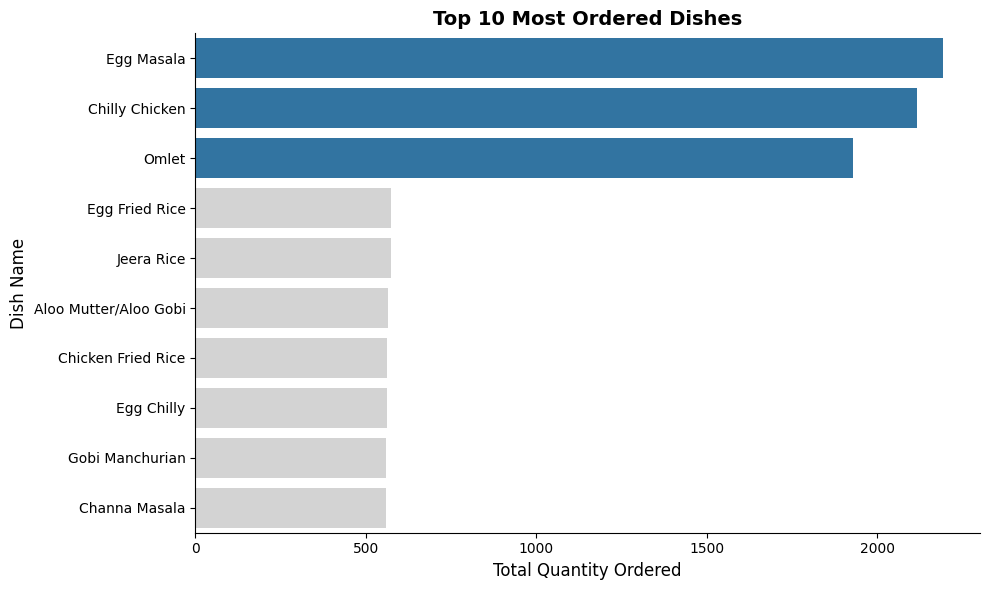

In [113]:
# Group and sort
top_dishes = merged_df.groupby('Dish_Ordered')['Quantity_Ordered'].sum().sort_values(ascending=False).head(10)

# Colors: Top 3 in blue, rest in light grey
colors = ['#1f77b4' if i < 3 else '#d3d3d3' for i in range(len(top_dishes))]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_dishes.values, y=top_dishes.index, palette=colors)

# Title and labels
plt.title("Top 10 Most Ordered Dishes", fontsize=14, weight='bold')
plt.xlabel("Total Quantity Ordered", fontsize=12)
plt.ylabel("Dish Name", fontsize=12)

# Clean up look
sns.despine(left=False, bottom=False)  # Keep x and y axis lines
plt.grid(False)  # No background grid

plt.tight_layout()
plt.show()


In [115]:
top3_total = top_dishes.values[:3].sum()
top10_total = top_dishes.values.sum()
percentage = top3_total / top10_total * 100

In [117]:
percentage 

61.18246886949701

##### B. Which dishes are being ordered more often, even if in small quantities?

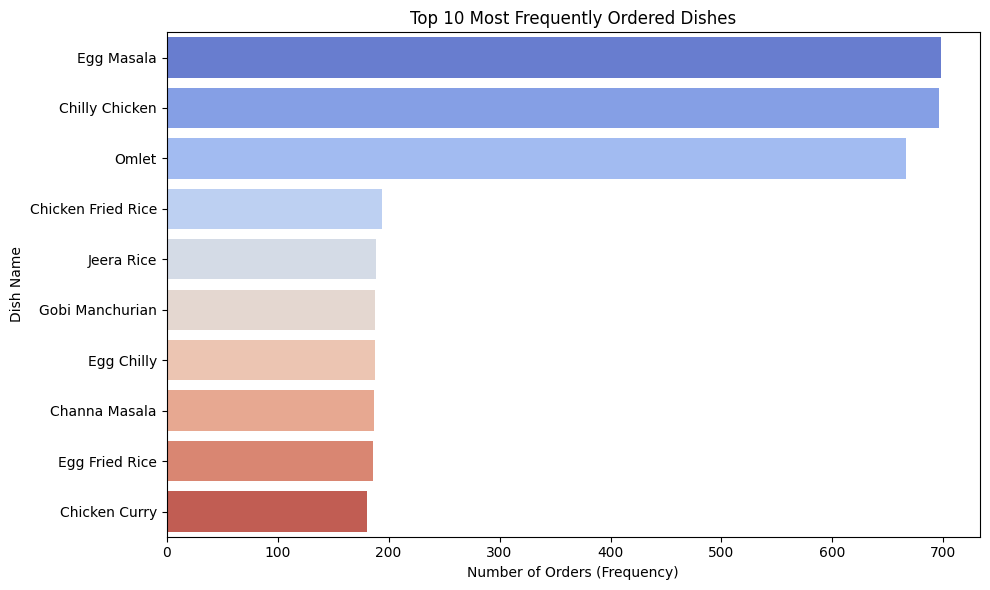

In [119]:
dish_frequency = merged_df['Dish_Ordered'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=dish_frequency.values, y=dish_frequency.index, palette='coolwarm')
plt.title("Top 10 Most Frequently Ordered Dishes")
plt.xlabel("Number of Orders (Frequency)")
plt.ylabel("Dish Name")
plt.tight_layout()
plt.show()


##### C. Do dishes with fewer ingredients get ordered more?

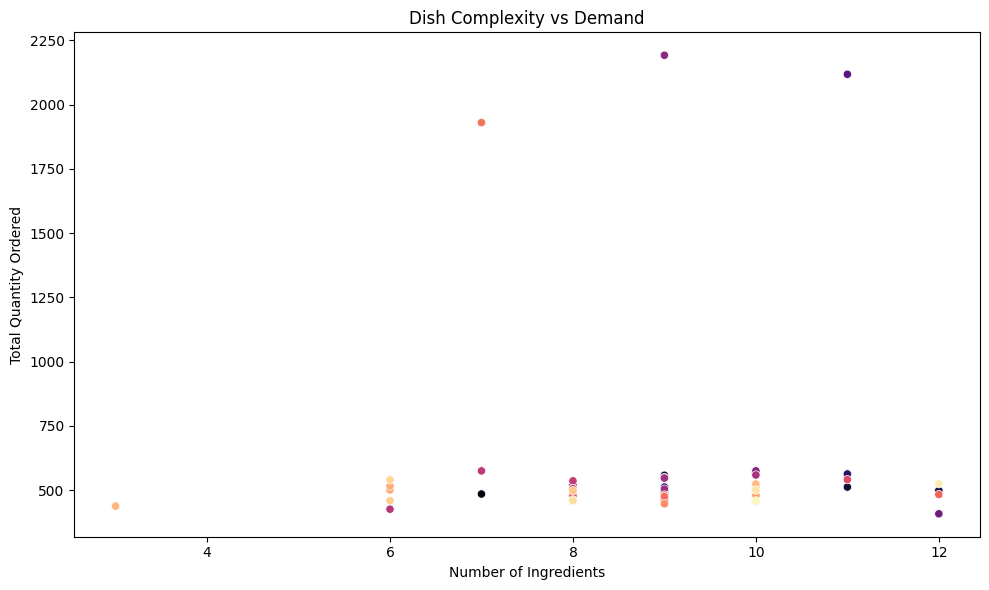

In [127]:
complexity_vs_demand = merged_df.groupby('Dish_Ordered').agg({
    'Quantity_Ordered': 'sum',
    'Num_Ingredients': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=complexity_vs_demand,
    x='Num_Ingredients',
    y='Quantity_Ordered',
    hue='Dish_Ordered',
    legend=False,
    palette='magma'
)

plt.title("Dish Complexity vs Demand")
plt.xlabel("Number of Ingredients")
plt.ylabel("Total Quantity Ordered")
plt.tight_layout()
plt.show()


#### 2. Orders by Time of Day (Morning, Afternoon, Evening, Night)


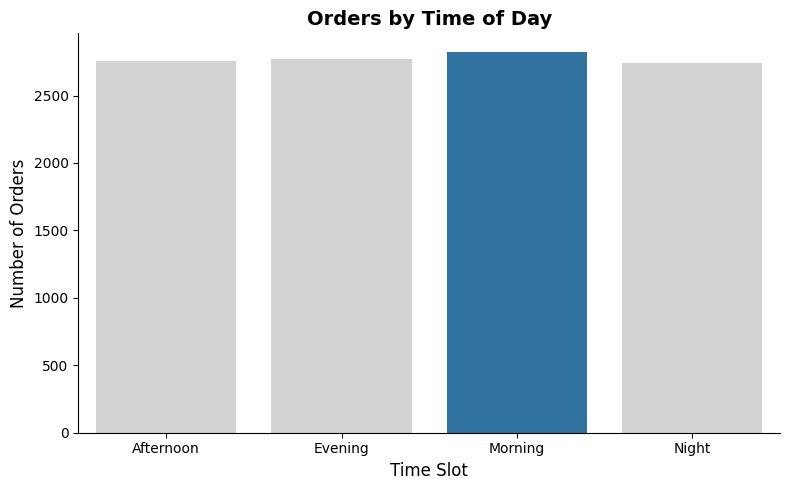

In [129]:
# Count number of orders per time slot
order_time_dist = merged_df['Order_Time'].value_counts().sort_index()

# Identify the time slot with the highest orders
max_idx = order_time_dist.values.argmax()

# Define colors: highlight the busiest slot
colors = ['#1f77b4' if i == max_idx else '#d3d3d3' for i in range(len(order_time_dist))]

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=order_time_dist.index, y=order_time_dist.values, palette=colors)

# Titles and labels
plt.title("Orders by Time of Day", fontsize=14, weight='bold')
plt.xlabel("Time Slot", fontsize=12)
plt.ylabel("Number of Orders", fontsize=12)

# Keep clean axes
sns.despine(left=False, bottom=False)
plt.grid(False)

plt.tight_layout()
plt.show()


##### B. which dishes are popular in which time slots

In [131]:
dish_time = merged_df.groupby(['Order_Time', 'Dish_Ordered'])['Quantity_Ordered'].sum().reset_index()
dish_time.head(5)

,Order_Time,Dish_Ordered,Quantity_Ordered
0,Afternoon,Aloo Mutter/Aloo Gobi,145
1,Afternoon,Aloo Posto,86
2,Afternoon,Bangda Fry,143
3,Afternoon,Butter Chicken,144
4,Afternoon,Butter Dhal Fry,116


In [133]:
dish_time['Order_Time'].value_counts()


Order_Time
Afternoon    57
Evening      57
Morning      57
Night        57
Name: count, dtype: int64

In [135]:
# Sort and get top 5 dishes per time slot
# Now get top 5 dishes per slot safely
top_dishes_timewise = (
    dish_time.groupby('Order_Time', group_keys=False)
    .apply(lambda x: x.nlargest(5, 'Quantity_Ordered'))
).reset_index(drop=True)

top_dishes_timewise['Order_Time'].value_counts()



Order_Time
Afternoon    5
Evening      5
Morning      5
Night        5
Name: count, dtype: int64

In [137]:
top_dishes_timewise

,Order_Time,Dish_Ordered,Quantity_Ordered
0,Afternoon,Egg Masala,658
1,Afternoon,Chilly Chicken,540
2,Afternoon,Omlet,464
3,Afternoon,Gobi Manchurian,165
4,Afternoon,Jeera Rice,162
5,Evening,Chilly Chicken,582
6,Evening,Egg Masala,546
7,Evening,Omlet,466
8,Evening,Chicken Curry,171
9,Evening,Egg Fried Rice,165


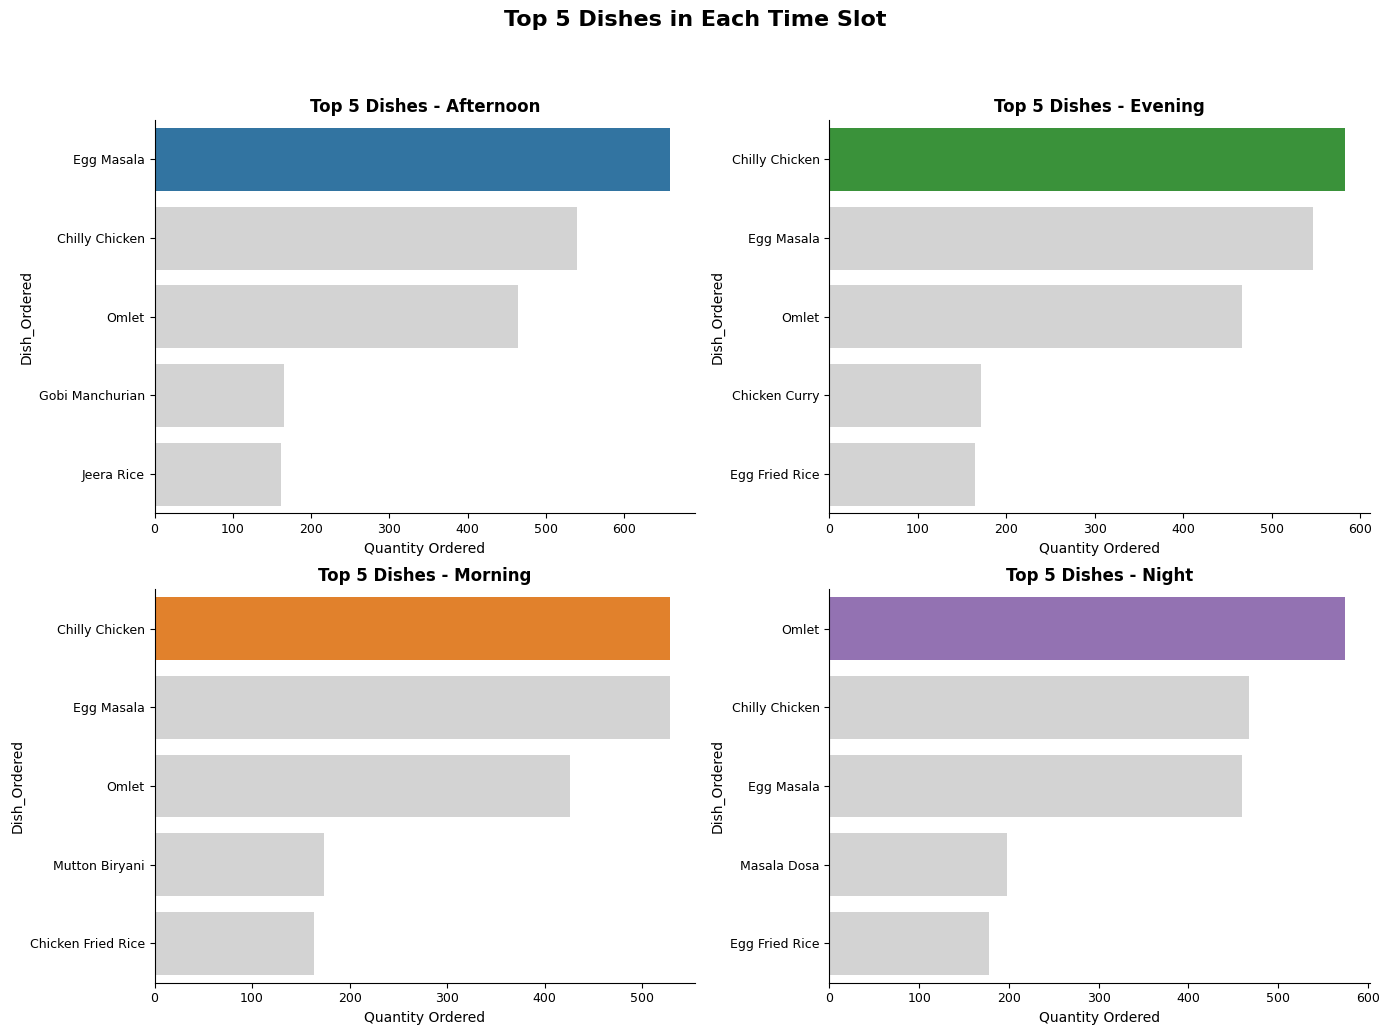

In [139]:
time_slots = top_dishes_timewise['Order_Time'].unique()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

# Define distinct highlight colors for each time slot
highlight_colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd']  # blue, green, orange, purple

for i, time in enumerate(time_slots):
    temp_df = top_dishes_timewise[top_dishes_timewise['Order_Time'] == time].reset_index(drop=True)

    # First row is the top dish — give it a unique color, others get grey
    colors = [highlight_colors[i] if j == 0 else '#d3d3d3' for j in range(len(temp_df))]

    sns.barplot(
        data=temp_df,
        x='Quantity_Ordered',
        y='Dish_Ordered',
        palette=colors,
        ax=axes[i]
    )

    axes[i].set_title(f"Top 5 Dishes - {time}", fontsize=12, weight='bold')
    axes[i].set_xlabel("Quantity Ordered", fontsize=10)
    axes[i].set_ylabel("Dish_Ordered", fontsize=10)
    axes[i].tick_params(labelsize=9)
    sns.despine(ax=axes[i])

# Hide unused axes if less than 4 slots
for j in range(i + 1, 4):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Top 5 Dishes in Each Time Slot", fontsize=16, weight='bold', y=1.03)
plt.subplots_adjust(top=0.92)
plt.show()


#### 3.  Orders by Weekday (Monday to Sunday)


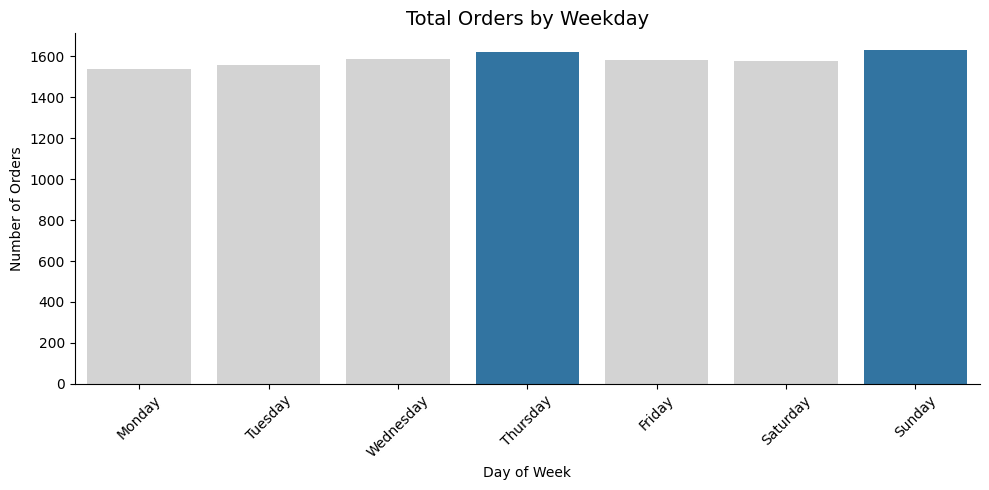

In [141]:
# Total orders per weekday (in correct order)
weekday_orders = merged_df['Weekday'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Find top 2 weekdays with highest orders
top2_days = weekday_orders.sort_values(ascending=False).head(2).index

# Assign color: blue for top 2 days, gray for others
colors = ['#1f77b4' if day in top2_days else 'lightgray' for day in weekday_orders.index]

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_orders.index, y=weekday_orders.values, palette=colors)

plt.title("Total Orders by Weekday", fontsize=14)
plt.xlabel("Day of Week")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
sns.despine(left=False, bottom=False)

plt.tight_layout()
plt.show()


##### B. Which dishes dominate on which day

In [143]:
weekday_dishes = (
    merged_df.groupby(['Weekday', 'Dish_Ordered'])['Quantity_Ordered']
    .sum()
    .reset_index()
)



In [145]:
top3_weekday_dishes = (
    weekday_dishes.groupby('Weekday', group_keys=False)
    .apply(lambda x: x.nlargest(3, 'Quantity_Ordered'))
).reset_index(drop=True)


In [147]:
# To ensure correct weekday order in plot
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
top3_weekday_dishes['Weekday'] = pd.Categorical(top3_weekday_dishes['Weekday'], categories=day_order, ordered=True)
top3_weekday_dishes = top3_weekday_dishes.sort_values(['Weekday', 'Quantity_Ordered'], ascending=[True, False])


C:\Users\SOUNDARYA\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


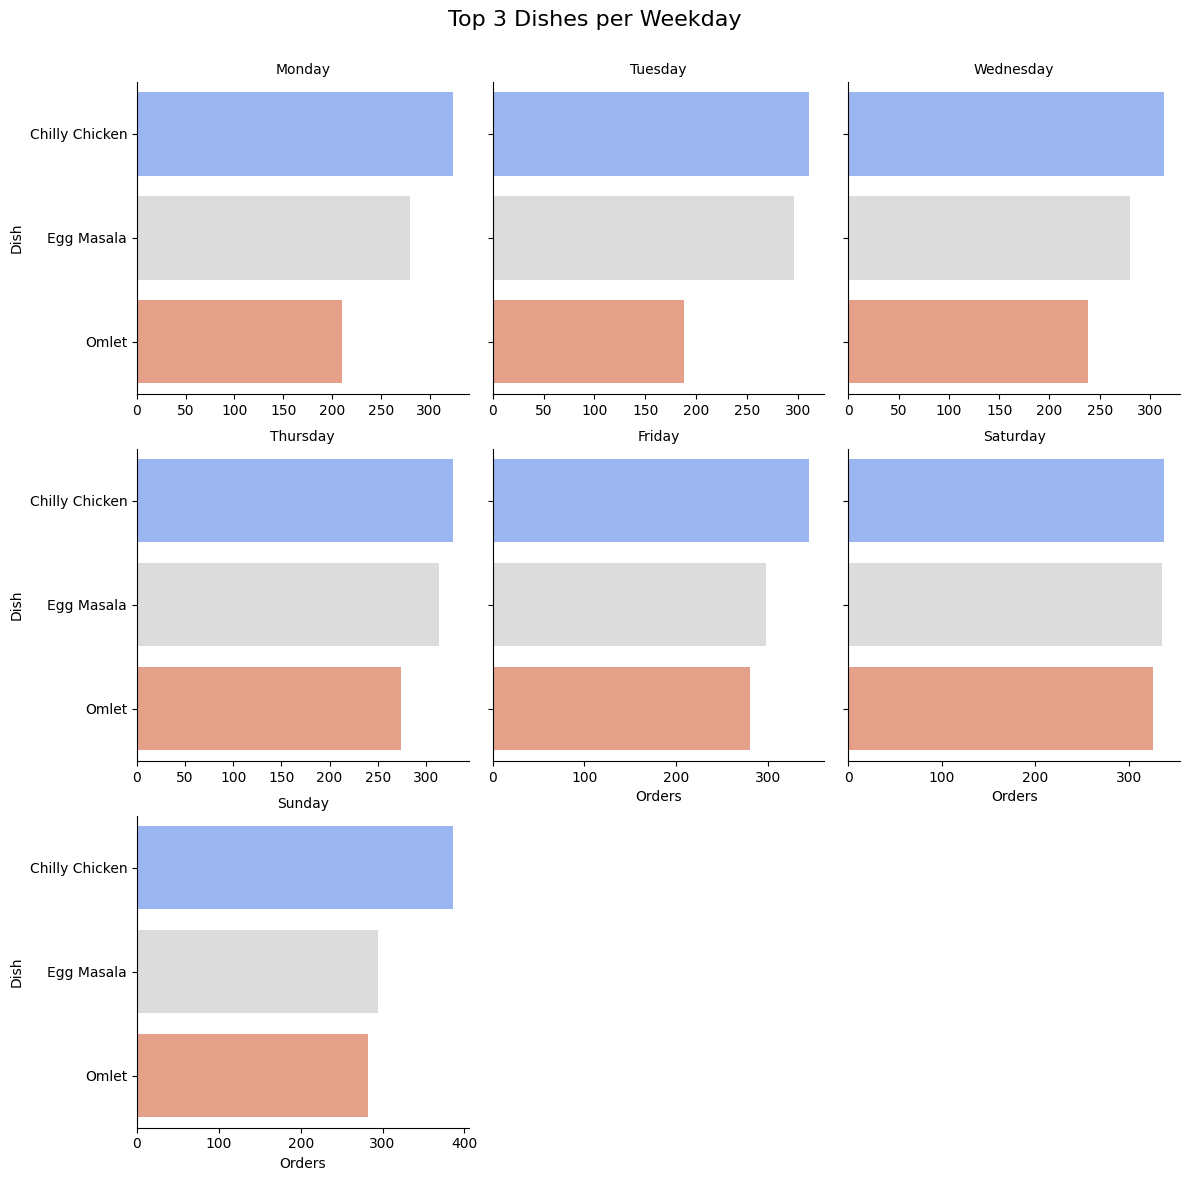

In [149]:
g = sns.FacetGrid(top3_weekday_dishes, col='Weekday', col_wrap=3, height=4, sharex=False)
g.map_dataframe(
    sns.barplot,
    y='Dish_Ordered',
    x='Quantity_Ordered',
    palette='coolwarm'
)

g.set_titles("{col_name}")
g.set_axis_labels("Orders", "Dish")
g.tight_layout()
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Top 3 Dishes per Weekday", fontsize=16)
plt.show()


#### 4. Orders by Month — Seasonality Trends


In [151]:
# Correct month order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

merged_df['Month'] = pd.Categorical(merged_df['Month'], categories=month_order, ordered=True)


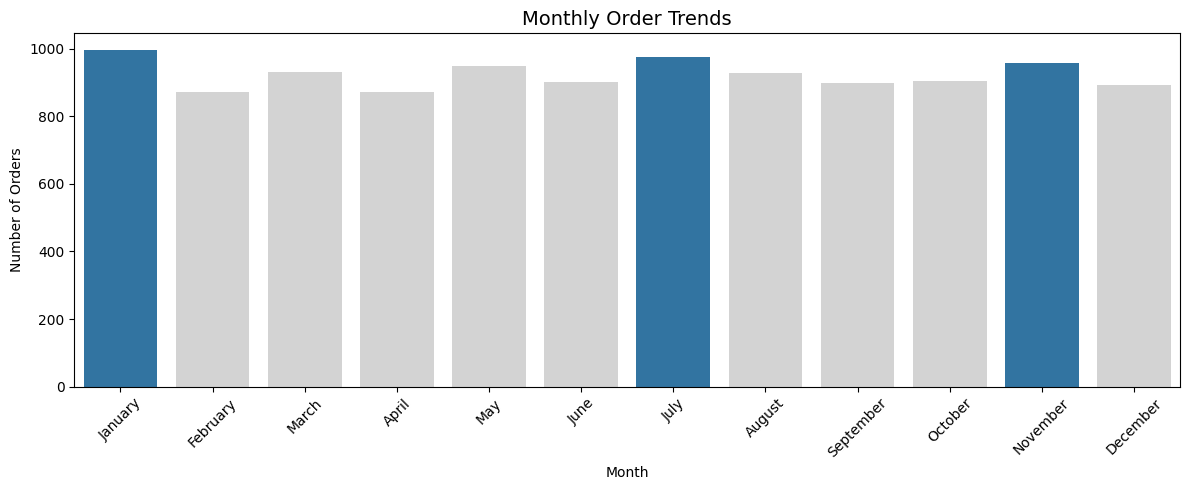

In [153]:
# Correct month order
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

merged_df['Month'] = pd.Categorical(merged_df['Month'], categories=month_order, ordered=True)

# Count orders per month
monthly_orders = merged_df['Month'].value_counts().reindex(month_order)

# Identify top 3 months
top_months = monthly_orders.sort_values(ascending=False).head(3).index

# Define color palette: blue for top 3, grey for others
colors = ['#1f77b4' if month in top_months else 'lightgrey' for month in monthly_orders.index]

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x=monthly_orders.index, y=monthly_orders.values, palette=colors)

plt.title("Monthly Order Trends", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### B. Check if holiday months bring more orders than regular months.

In [155]:
# Add Month to holidays_df
holidays_df['Month'] = pd.to_datetime(holidays_df['Date']).dt.month_name()

# Count number of holidays in each month
holiday_counts = holidays_df['Month'].value_counts().reindex(month_order)

# Total orders per month (already from merged_df)
order_counts = merged_df['Month'].value_counts().reindex(month_order)

# Combine into one DataFrame
month_comparison = pd.DataFrame({
    'Month': month_order,
    'Holiday_Count': holiday_counts.values,
    'Order_Count': order_counts.values
})

month_comparison.fillna(0, inplace=True)


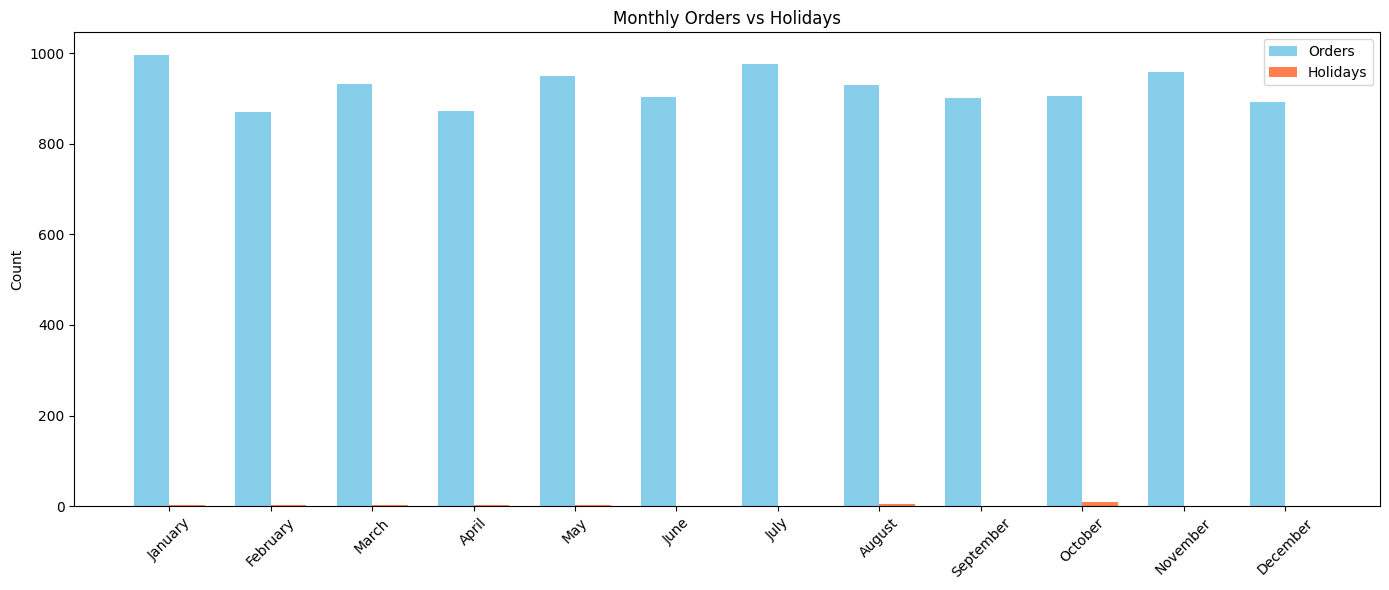

In [157]:
x = np.arange(len(month_order))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, month_comparison['Order_Count'], width, label='Orders', color='skyblue')
plt.bar(x + width/2, month_comparison['Holiday_Count'], width, label='Holidays', color='coral')

plt.xticks(x, month_order, rotation=45)
plt.ylabel("Count")
plt.title("Monthly Orders vs Holidays")
plt.legend()
plt.tight_layout()
plt.show()


##### C. Top Dishes by Month

In [159]:
# Group and get quantity ordered per dish per month
dish_month = (
    merged_df.groupby(['Month', 'Dish_Ordered'])['Quantity_Ordered']
    .sum()
    .reset_index()
)

# Make sure month is ordered correctly
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

dish_month['Month'] = pd.Categorical(dish_month['Month'], categories=month_order, ordered=True)

# Get Top 3 Dishes per Month
top_dishes_by_month = (
    dish_month.groupby('Month', group_keys=False)
    .apply(lambda x: x.nlargest(3, 'Quantity_Ordered'))
).reset_index(drop=True)



C:\Users\SOUNDARYA\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


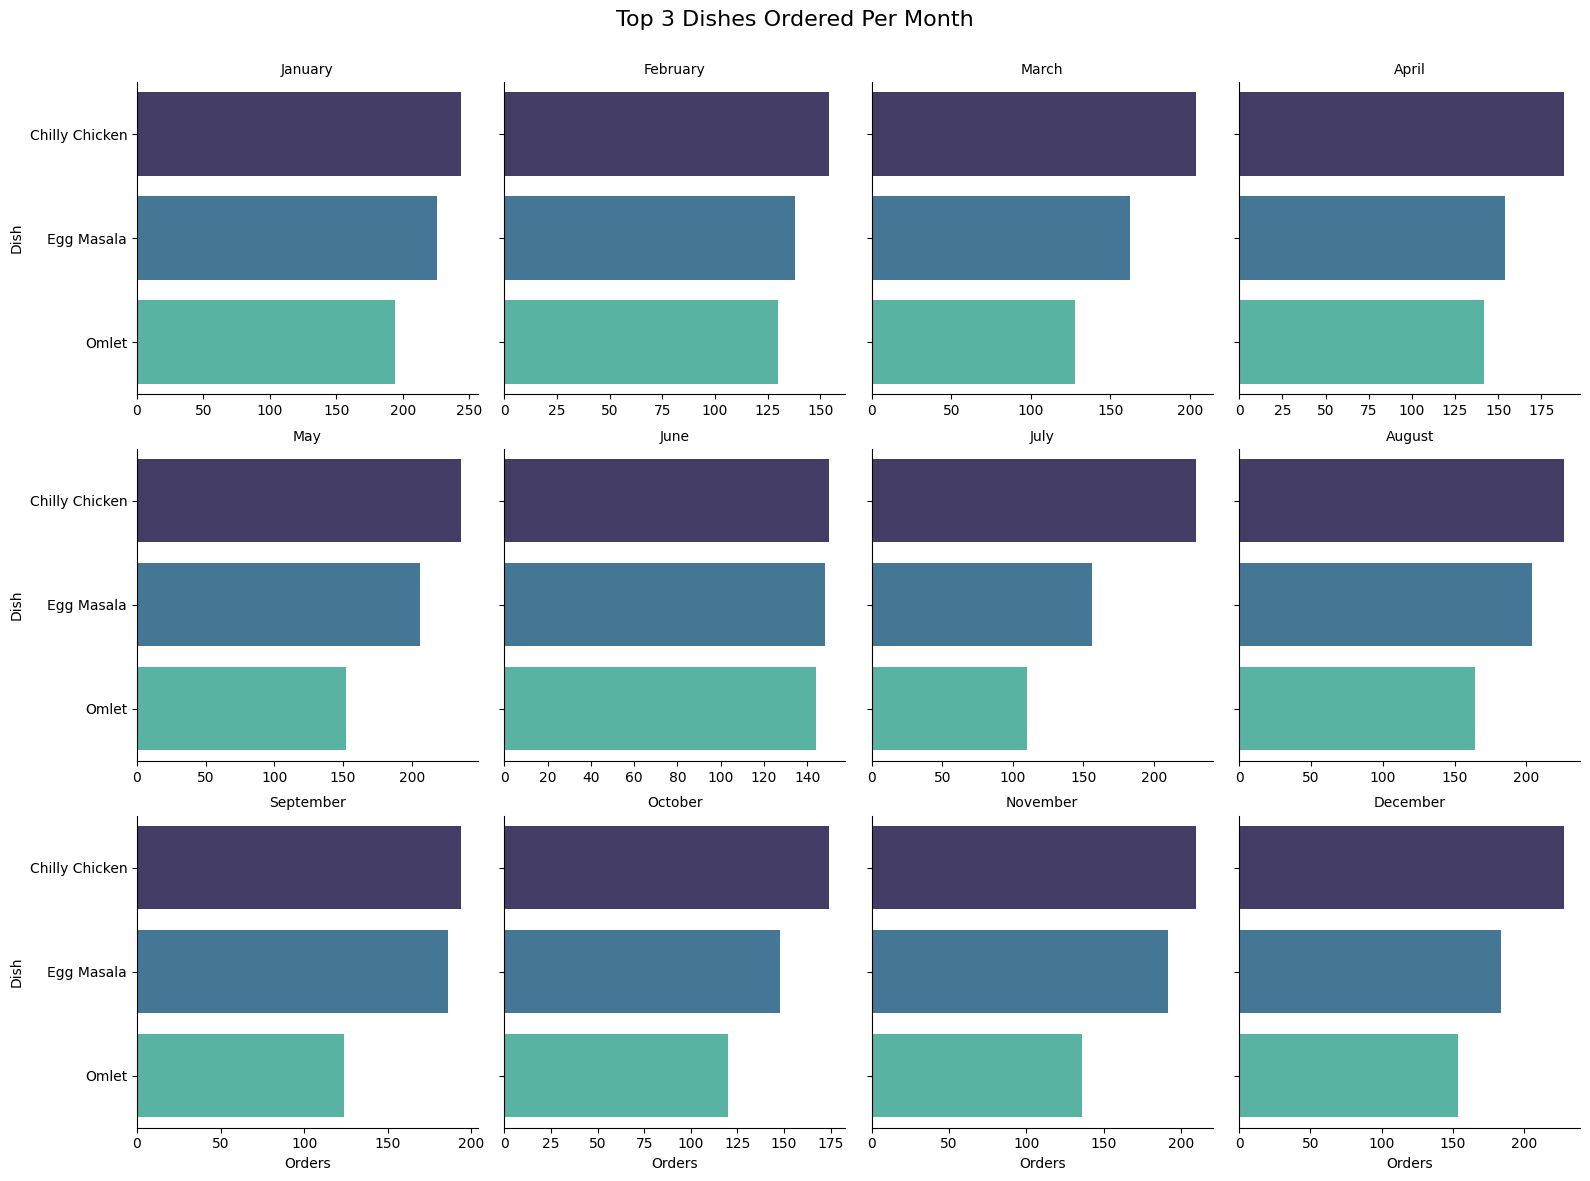

In [161]:

# Create grid layout for each month
g = sns.FacetGrid(top_dishes_by_month, col='Month', col_wrap=4, height=4, sharex=False)

# Plot barplot for each month
g.map_dataframe(
    sns.barplot,
    y='Dish_Ordered',
    x='Quantity_Ordered',
    palette='mako'
)

# Titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Orders", "Dish")
g.tight_layout()
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Top 3 Dishes Ordered Per Month", fontsize=16)
plt.show()


##### D.  Wastage Trends by Month

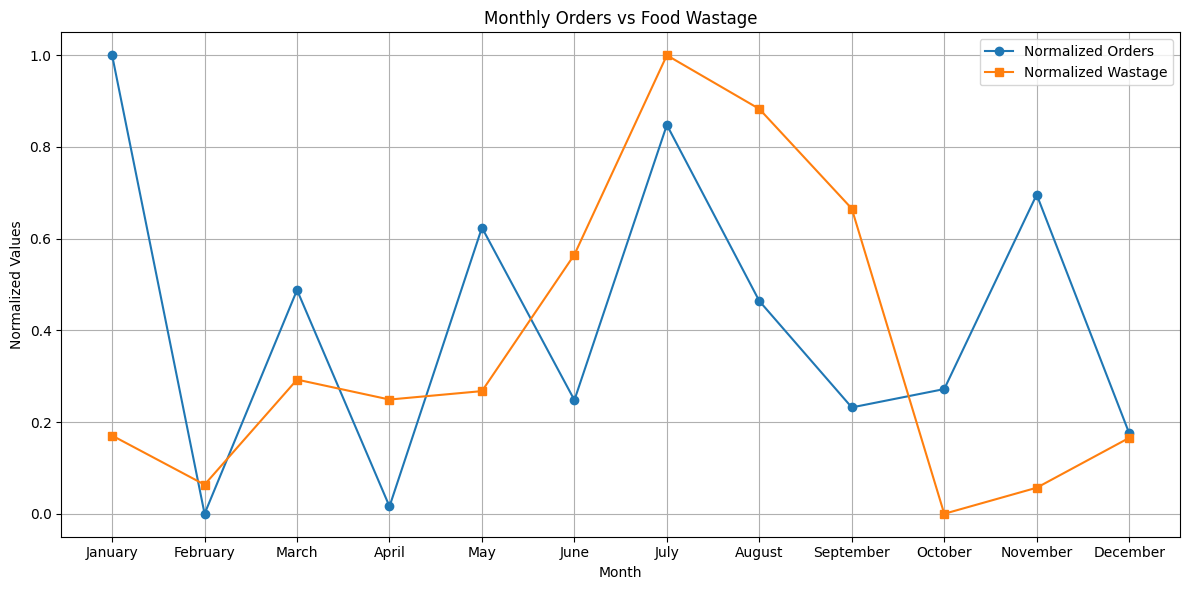

In [165]:
wastage_df['Month'] = pd.to_datetime(wastage_df['Date']).dt.month_name()
waste_by_month = wastage_df.groupby('Month')['Wastage_kg'].sum().reindex(month_order)

# Reuse order count from before
orders_by_month = merged_df['Month'].value_counts().reindex(month_order)

# Normalize both for comparison
orders_norm = (orders_by_month - orders_by_month.min()) / (orders_by_month.max() - orders_by_month.min())
waste_norm = (waste_by_month - waste_by_month.min()) / (waste_by_month.max() - waste_by_month.min())

# Plot line chart
plt.figure(figsize=(12, 6))
plt.plot(month_order, orders_norm, label='Normalized Orders', marker='o')
plt.plot(month_order, waste_norm, label='Normalized Wastage', marker='s')
plt.title("Monthly Orders vs Food Wastage")
plt.xlabel("Month")
plt.ylabel("Normalized Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### 5. Holiday vs Non-Holiday Dish Demand


In [167]:
# Group and Compare Dish Demand by Holiday Status

holiday_vs_normal = (
    merged_df.groupby(['is_holiday', 'Dish_Ordered'])['Quantity_Ordered']
    .sum()
    .reset_index()
)


In [169]:
top_holiday_dishes = (
    holiday_vs_normal[holiday_vs_normal['is_holiday'] == 1]
    .sort_values(by='Quantity_Ordered', ascending=False)
    .head(10)
)

top_normal_dishes = (
    holiday_vs_normal[holiday_vs_normal['is_holiday'] == 0]
    .sort_values(by='Quantity_Ordered', ascending=False)
    .head(10)
)


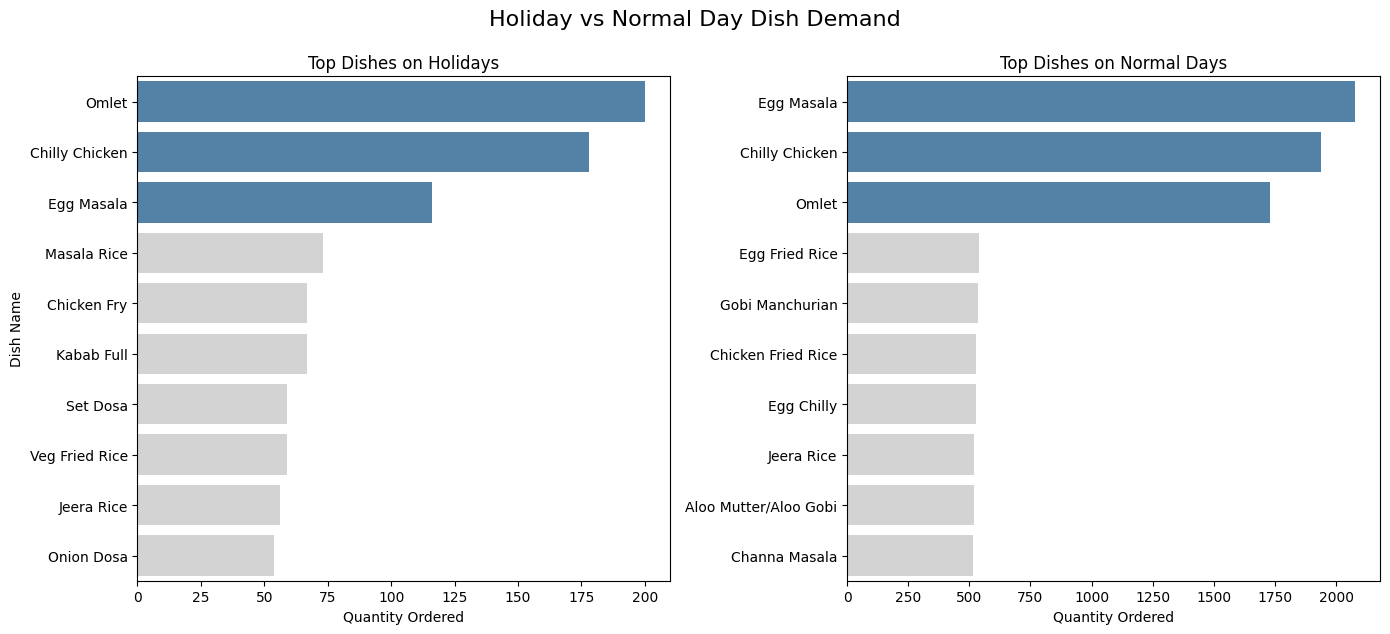

In [173]:
def get_custom_palette(df, top_n=3, highlight_color='steelblue', default_color='lightgray'):
    palette = []
    for i in range(len(df)):
        if i < top_n:
            palette.append(highlight_color)
        else:
            palette.append(default_color)
    return palette

# Generate palettes
holiday_palette = get_custom_palette(top_holiday_dishes)
normal_palette = get_custom_palette(top_normal_dishes)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False)

# Holiday Orders
sns.barplot(
    data=top_holiday_dishes,
    x='Quantity_Ordered',
    y='Dish_Ordered',
    ax=axes[0],
    palette=holiday_palette
)
axes[0].set_title("Top Dishes on Holidays")
axes[0].set_xlabel("Quantity Ordered")
axes[0].set_ylabel("Dish Name")

# Non-Holiday Orders
sns.barplot(
    data=top_normal_dishes,
    x='Quantity_Ordered',
    y='Dish_Ordered',
    ax=axes[1],
    palette=normal_palette
)
axes[1].set_title("Top Dishes on Normal Days")
axes[1].set_xlabel("Quantity Ordered")
axes[1].set_ylabel("")

plt.tight_layout()
plt.suptitle("Holiday vs Normal Day Dish Demand", fontsize=16, y=1.05)
plt.show()


##### B. Total Revenue — Holiday vs Non-Holiday

In [175]:

np.random.seed(42)  # for reproducibility

# Unique dishes
dishes = merged_df['Dish_Ordered'].unique()

# Assign random prices between ₹80 and ₹250
dish_prices = {dish: np.random.randint(80, 251) for dish in dishes}

# Map to merged_df
merged_df['Dish_Price'] = merged_df['Dish_Ordered'].map(dish_prices)

# Calculate total value per row
merged_df['Total_Value'] = merged_df['Quantity_Ordered'] * merged_df['Dish_Price']


In [177]:
# Compare Total Revenue (Holiday vs Non-Holiday)

revenue_by_day_type = (
    merged_df.groupby('is_holiday')['Total_Value']
    .sum()
    .reset_index()
)

# Rename for clarity
revenue_by_day_type['Day_Type'] = revenue_by_day_type['is_holiday'].map({0: 'Non-Holiday', 1: 'Holiday'})


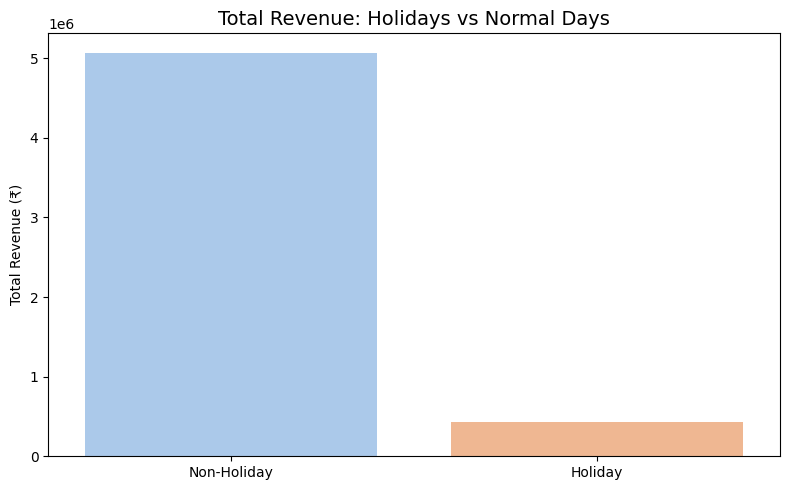

In [179]:
plt.figure(figsize=(8, 5))
sns.barplot(
    data=revenue_by_day_type,
    x='Day_Type',
    y='Total_Value',
    palette='pastel'
)
plt.title("Total Revenue: Holidays vs Normal Days", fontsize=14)
plt.ylabel("Total Revenue (₹)")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [181]:
# Revenue per Day (trendline across time):
daily_revenue = merged_df.groupby('Order_Date')['Total_Value'].sum().reset_index()
daily_revenue.head(2)

,Order_Date,Total_Value
0,2022-01-01,13732
1,2022-01-02,23072


In [183]:
#Top Earning Dishes Overall:
merged_df.groupby('Dish_Ordered')['Total_Value'].sum().sort_values(ascending=False).head(10)


Dish_Ordered
Chilly Chicken     425718
Egg Masala         416480
Omlet              378280
Math Curry         119769
Chicken Biryani    119760
Channa Masala      117738
Egg Noodles        117315
Palak Paneer       117019
Chicken Noodles    115500
Tomato Fry         112914
Name: Total_Value, dtype: int64

In [185]:
# Revenue by Payment Method:
merged_df.groupby('Payment_Method')['Total_Value'].sum().sort_values(ascending=False)


Payment_Method
Cash      1384225
Wallet    1379400
UPI       1371440
Card      1361933
Name: Total_Value, dtype: int64

#### 6. Ingredient Load vs Dish Popularity


In [187]:
# Already done previously
merged_df['Num_Ingredients'] = merged_df['Ingredients_List'].apply(len)


In [189]:
dish_insight = (
    merged_df.groupby('Dish_Ordered')
    .agg(
        Total_Orders=('Quantity_Ordered', 'sum'),
        Avg_Ingredients=('Num_Ingredients', 'mean')
    )
    .reset_index()
)


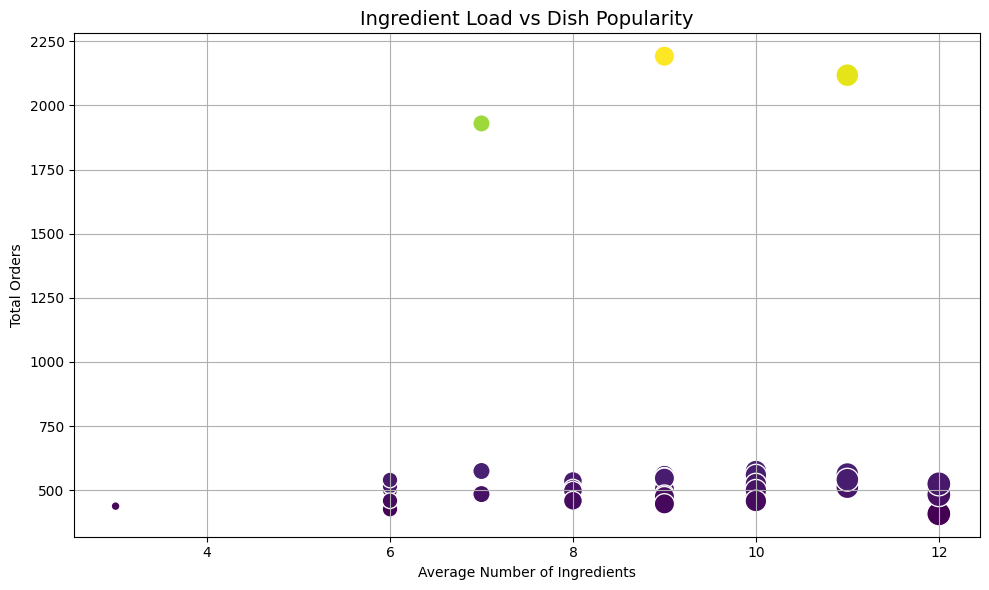

In [191]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=dish_insight,
    x='Avg_Ingredients',
    y='Total_Orders',
    hue='Total_Orders',
    size='Avg_Ingredients',
    sizes=(40, 300),
    palette='viridis',
    legend=False
)

plt.title("Ingredient Load vs Dish Popularity", fontsize=14)
plt.xlabel("Average Number of Ingredients")
plt.ylabel("Total Orders")
plt.grid(True)
plt.tight_layout()
plt.show()


#### 7. Time-Based Demand Forecasting (Trends Over Time)

In [193]:
# Daily Dish Demand Trends
daily_demand = (
    merged_df.groupby('Order_Date')['Quantity_Ordered']
    .sum()
    .reset_index()
)


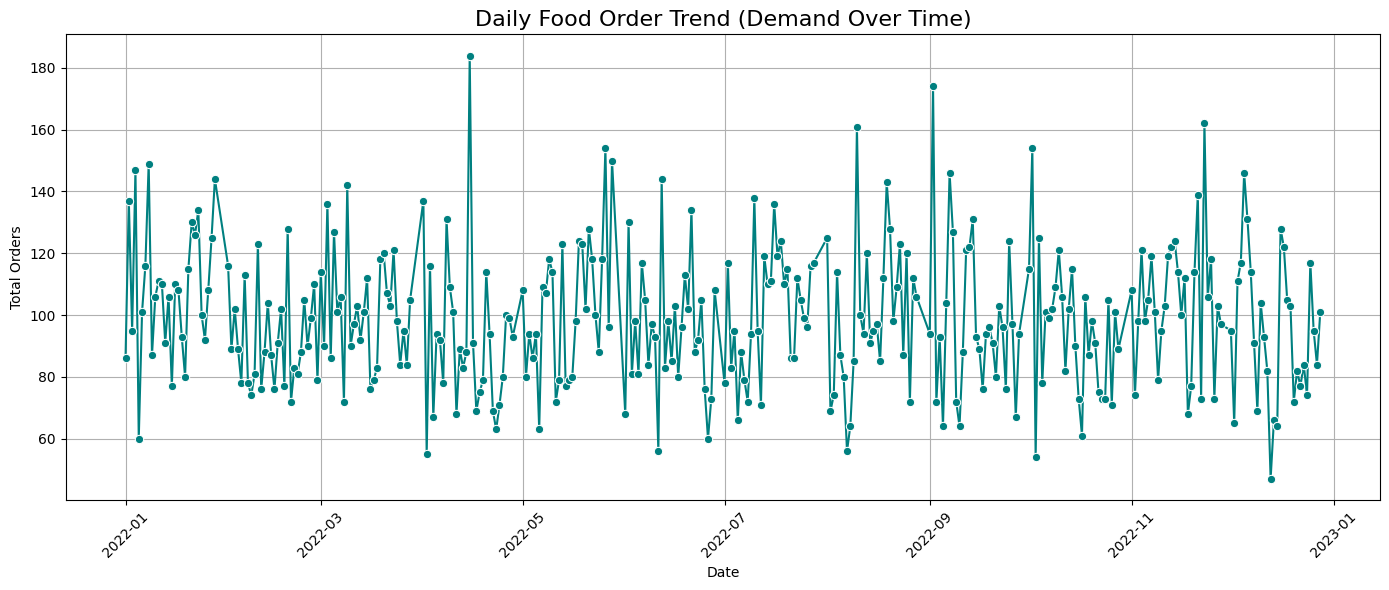

In [197]:
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=daily_demand,
    x='Order_Date',
    y='Quantity_Ordered',
    color='teal',
    marker='o'
)
plt.title("Daily Food Order Trend (Demand Over Time)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Total Orders")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [199]:
# Weekly or Monthly Aggregation (Optional)
# Weekly demand
weekly_demand = (
    merged_df.groupby('Week')['Quantity_Ordered']
    .sum()
    .reset_index()
)

# Monthly demand
monthly_demand = (
    merged_df.groupby('Month_Num')['Quantity_Ordered']
    .sum()
    .reset_index()
)


In [201]:
merged_df.to_csv("merged_data.csv", index=False)

In [203]:
merged_df.head(2)

,Customer_ID,Customer_Name,Month,Dish_Ordered,Quantity_Ordered,Order_Time,Payment_Method,Month_Num,Day,Order_Date,Dish_Name,Ingredients_List,is_holiday,Weekday,Week,Num_Ingredients,Dish_Price,Total_Value
0,5792,Rajesh Gupta,August,Aloo Posto,3,Evening,Cash,8,25,2022-08-25,Aloo Posto,"[potato, poppy seeds, mustard oil, green chili...",0,Thursday,34,7,182,546
1,8481,Rajesh Gupta,June,Egg Chilly,1,Night,Card,6,14,2022-06-14,Egg Chilly,"[egg, capsicum, soy sauce, garlic, onion, oil,...",0,Tuesday,24,10,172,172


## Forecasting

In [245]:
# Forecasting-ready dataset
forecast_df = daily_demand.rename(columns={
    'Order_Date': 'ds',
    'Quantity_Ordered': 'y'
})

forecast_df.head()


,ds,y
0,2022-01-01,114
1,2022-01-02,141
2,2022-01-03,111
3,2022-01-04,71
4,2022-01-05,110


In [247]:
forecast_df.tail()

,ds,y
331,2022-12-24,89
332,2022-12-25,90
333,2022-12-26,131
334,2022-12-27,59
335,2022-12-28,72


In [228]:
# !pip install prophet
from prophet import Prophet


In [249]:
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])


In [251]:
# Initialize and Fit Prophet

model = Prophet()
model.fit(forecast_df)


11:01:34 - cmdstanpy - INFO - Chain [1] start processing
11:01:36 - cmdstanpy - INFO - Chain [1] done processing


In [281]:
# Create Future Dates & Forecast

# Create 30 future days
future = model.make_future_dataframe(periods=30)

# Predict
forecast = model.predict(future)


In [289]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01,100.742000,66.128495,122.783815,100.742000,100.742000,-4.726617,-4.726617,-4.726617,-4.726617,-4.726617,-4.726617,0.0,0.0,0.0,96.015383
1,2022-01-02,100.730597,77.362764,132.693072,100.730597,100.730597,6.464545,6.464545,6.464545,6.464545,6.464545,6.464545,0.0,0.0,0.0,107.195142
2,2022-01-03,100.719194,72.937033,130.940141,100.719194,100.719194,1.782107,1.782107,1.782107,1.782107,1.782107,1.782107,0.0,0.0,0.0,102.501300
3,2022-01-04,100.707791,69.027407,125.443574,100.707791,100.707791,-3.163461,-3.163461,-3.163461,-3.163461,-3.163461,-3.163461,0.0,0.0,0.0,97.544330
4,2022-01-05,100.696388,65.011238,122.966681,100.696388,100.696388,-7.179116,-7.179116,-7.179116,-7.179116,-7.179116,-7.179116,0.0,0.0,0.0,93.517272


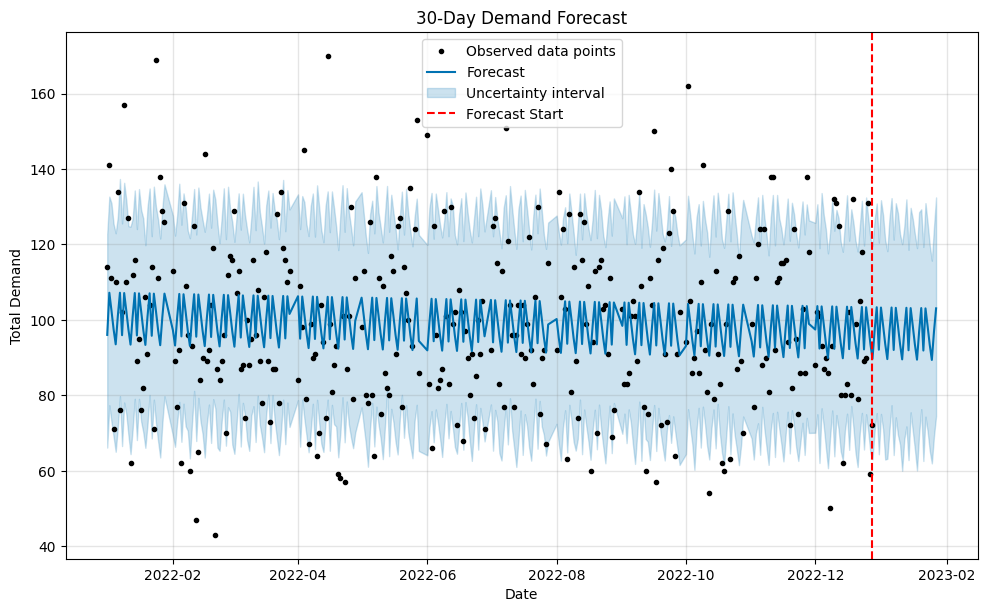

In [285]:
# Get the last date of your training data
last_train_date = forecast_df['ds'].max()

fig = model.plot(forecast)
plt.title("30-Day Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Total Demand")

# Add red line to show start of forecast
plt.axvline(x=last_train_date, color='red', linestyle='--', label='Forecast Start')
plt.legend()
plt.show()

### 📈 30-Day Demand Forecast Insight

- **Forecast Overview**:  
  The Prophet model predicts that **restaurant demand will remain stable** over the next 30 days, with no significant upward or downward trend.

- **Forecast Confidence (Shaded Blue Area)**:  
  The shaded region represents the model's **uncertainty range** — where it's 95% confident the demand will fall. For most days, demand is expected to stay between **~70 and ~130 orders**.

- **Actual Demand (Black Dots)**:  
  The historical black dots show the **real past demand**. Most dots fall within the forecast range, indicating that the model has learned the pattern well. However, some outliers (very high or low demand days) suggest **occasional spikes or drops** — possibly due to promotions, events, or external factors.

- **Forecast Start (Red Line)**:  
  The red dashed line marks where the **future forecast begins**. Everything to the right of this line is **predicted demand** for the next 30 days.

This plot can guide **inventory planning, staffing, and daily prep** by giving visibility into expected order volumes and confidence intervals.


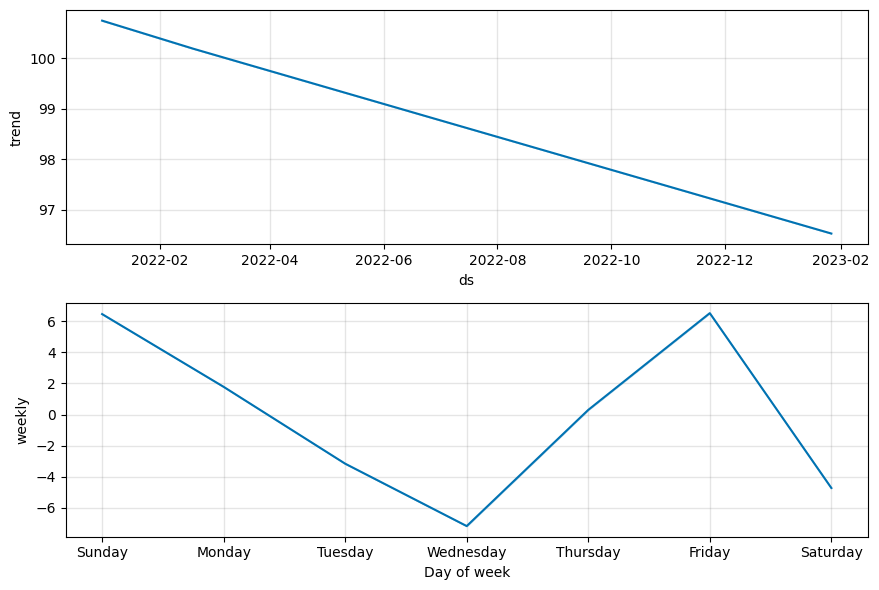

In [286]:
model.plot_components(forecast)
plt.show()


### 📊 Forecast Components Insight

- **Overall Trend**:  
  The long-term demand is showing a **slight downward trend** over the year. This suggests that customer demand at the restaurant has **gradually decreased** month over month. Potential causes could include reduced customer visits, increased competition, or seasonal shifts.

- **Weekly Seasonality**:  
  Demand varies across the week:
  - **Highest demand** on **Fridays and Sundays** — likely due to weekend dining patterns.
  - **Lowest demand** on **Wednesdays** — midweek slump in customer traffic.
  
  This weekly pattern can help with **staff planning, inventory management**, and **targeted promotions** (e.g., midweek offers to boost Wednesday sales).


In [259]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)


,ds,yhat,yhat_lower,yhat_upper
336,2022-12-29,97.136657,68.539240,123.947574
337,2022-12-30,103.353175,74.043243,131.818619
338,2022-12-31,92.091000,65.424960,121.132228
339,2023-01-01,103.271478,75.453142,131.766425
340,2023-01-02,98.578355,70.805585,127.992830
341,2023-01-03,93.622103,64.731795,120.852497
342,2023-01-04,89.595762,62.149114,115.653305
343,2023-01-05,97.061864,70.708917,124.864908
344,2023-01-06,103.278382,73.975764,130.213692
345,2023-01-07,92.016207,62.019526,119.572751


### Model Evaluation

In [296]:
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
print(f"Total days in dataset: {forecast_df['ds'].nunique()}")
print(f"Date range: {forecast_df['ds'].min()} to {forecast_df['ds'].max()}")


Total days in dataset: 336
Date range: 2022-01-01 00:00:00 to 2022-12-28 00:00:00


In [298]:
# Cross-Validation with prophet.diagnostics

from prophet.diagnostics import cross_validation

# horizon: how far into future to predict (e.g., 30 days)
# initial: how much history to train with first time
# period: how often to retrain the model
df_cv = cross_validation(model, 
                         initial='240 days', 
                         period='30 days', 
                         horizon='30 days')

  0%|          | 0/4 [00:00<?, ?it/s]

12:03:13 - cmdstanpy - INFO - Chain [1] start processing
12:03:13 - cmdstanpy - INFO - Chain [1] done processing
12:03:14 - cmdstanpy - INFO - Chain [1] start processing
12:03:14 - cmdstanpy - INFO - Chain [1] done processing
12:03:14 - cmdstanpy - INFO - Chain [1] start processing
12:03:14 - cmdstanpy - INFO - Chain [1] done processing
12:03:15 - cmdstanpy - INFO - Chain [1] start processing
12:03:15 - cmdstanpy - INFO - Chain [1] done processing


In [300]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-09-01,99.307284,69.962805,126.789153,103,2022-08-30
1,2022-09-02,103.067056,75.962758,132.289144,83,2022-08-30
2,2022-09-03,90.495235,59.392869,118.309414,83,2022-08-30
3,2022-09-04,102.356343,74.260983,129.903756,86,2022-08-30
4,2022-09-05,97.940366,67.719332,125.199248,101,2022-08-30


In [302]:
# Performance Metrics
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p[['horizon', 'mae', 'rmse', 'mape']]


,horizon,mae,rmse,mape
0,5 days,14.325757,19.398010,0.139228
1,6 days,10.216912,11.293467,0.107137
2,7 days,11.625072,14.389625,0.112324
3,8 days,11.958642,14.765393,0.119331
4,9 days,14.194106,16.758435,0.139311
5,10 days,20.695634,25.183431,0.235433
6,11 days,19.896473,24.711364,0.226497
7,12 days,23.589312,27.805770,0.250987
8,13 days,26.599743,29.285215,0.298138
9,14 days,25.368573,28.781320,0.288511


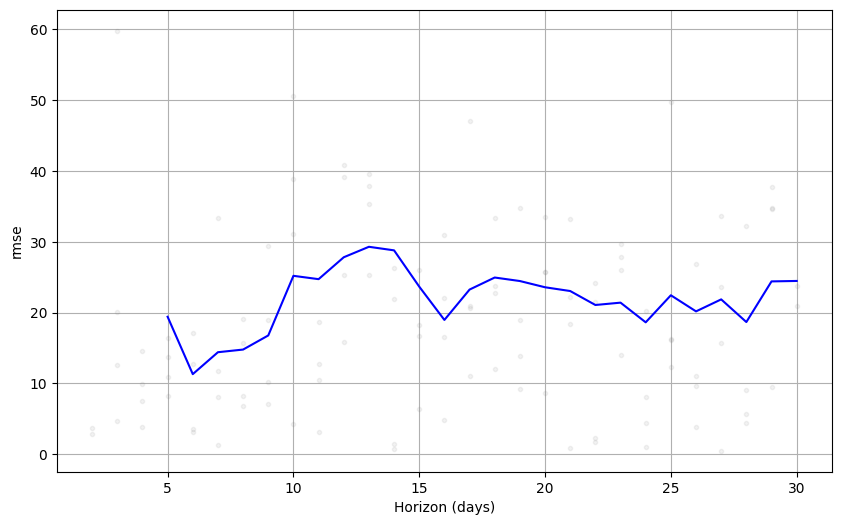

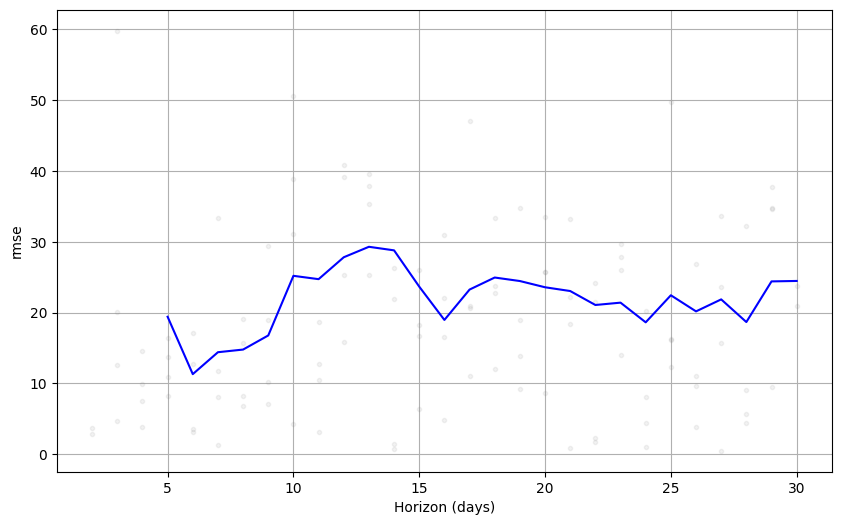

In [304]:
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric='rmse')


## Forecasting for specific dishes

“Initially, I forecasted total daily demand to understand the overall volume trend. But to make the solution more practical, I moved to dish-level forecasting. This allows the business to plan ingredient procurement, prep time, and menu availability more precisely.”

In [326]:
merged_df['Dish_Name'].value_counts()


Dish_Name
Egg Masala               704
Chilly Chicken           702
Omlet                    666
Chicken Fried Rice       193
Jeera Rice               189
Egg Chilly               189
Gobi Manchurian          189
Channa Masala            186
Egg Fried Rice           186
Chicken Curry            182
Ghee Rice                181
Aloo Mutter/Aloo Gobi    179
Chicken Noodles          178
Set Dosa                 177
Poori Bajji              175
Butter Chicken           175
Kabab Full               175
Cylon/Kerala Parota      175
Egg Torka                174
Veg Meals                174
Veg Fried Rice           172
Butter Dhal Fry          172
Kashmiri Aloo Dum        171
Chicken Biryani          171
Chicken Kosha            170
Parota                   169
Egg Noodles              169
Masala Dosa              169
Rohu                     168
Katla                    167
Chicken Pepper Masala    166
Chicken Do Pyaza         165
Paneer Butter Masala     165
Bangda Fry               165
Math

In [318]:
merged_df['Ingredients_List'].value_counts()

Ingredients_List
[egg, tomato, spices, onion, oil, garlic, ginger, salt, coriander]                                       704
[chicken, capsicum, soy sauce, vinegar, garlic, onion, ginger, corn flour, oil, green onion, spices]     702
[egg, salt, pepper, oil, onion, green chili, coriander]                                                  666
[chicken, yogurt, spices, garlic, ginger, salt, oil, lemon juice]                                        339
[rice, chicken, egg, soy sauce, garlic, onion, carrot, capsicum, oil, green onion, salt]                 193
[egg, capsicum, soy sauce, garlic, onion, oil, ginger, corn flour, green onion, spices]                  189
[rice, cumin seeds, ghee, salt, water, bay leaf, cloves]                                                 189
[cauliflower, soy sauce, garlic, ginger, corn flour, capsicum, onion, oil, green onion, spices]          189
[rice, egg, soy sauce, garlic, onion, carrot, capsicum, oil, green onion, salt]                          186
[c

In [328]:
# List of selected dishes
selected_dishes = [
    'Chicken Biryani', 
    'Paneer Butter Masala', 
    'Masala Dosa', 
    'Chicken Fried Rice', 
    'Chilly Chicken', 
    'Gobi Manchurian'
]

# Filter the dataset
df_filtered = merged_df[merged_df['Dish_Name'].isin(selected_dishes)]

# Check the filtered data
print(df_filtered['Dish_Name'].value_counts())


Dish_Name
Chilly Chicken          702
Chicken Fried Rice      193
Gobi Manchurian         189
Chicken Biryani         171
Masala Dosa             169
Paneer Butter Masala    165
Name: count, dtype: int64


In [337]:
# Group by Date and Dish, then sum the Quantity Ordered
df_grouped = df_filtered.groupby(['Order_Date', 'Dish_Name'])['Quantity_Ordered'].sum().reset_index()

# Convert Date column to datetime
df_grouped['Order_Date'] = pd.to_datetime(df_grouped['Order_Date'])

# Preview
df_grouped.head()


,Order_Date,Dish_Name,Quantity_Ordered
0,2022-01-01,Chicken Biryani,1
1,2022-01-01,Chilly Chicken,14
2,2022-01-01,Masala Dosa,1
3,2022-01-02,Chilly Chicken,18
4,2022-01-02,Gobi Manchurian,2


### Model building for forecasting specific dishes

In [335]:
from prophet.plot import plot_plotly



📈 Forecasting for: Chicken Biryani


13:12:04 - cmdstanpy - INFO - Chain [1] start processing
13:12:04 - cmdstanpy - INFO - Chain [1] done processing


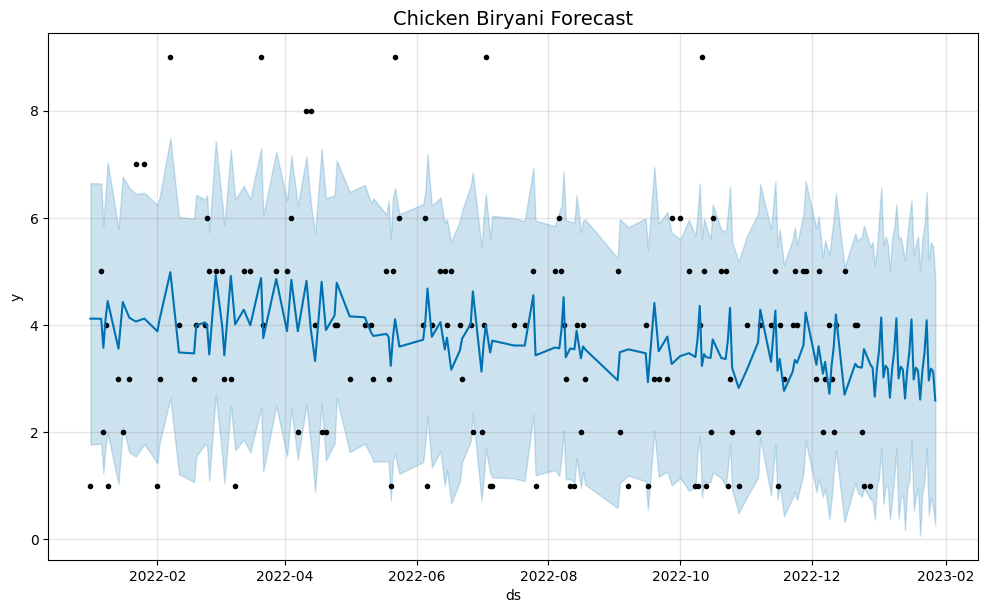


📈 Forecasting for: Chilly Chicken


13:12:05 - cmdstanpy - INFO - Chain [1] start processing
13:12:06 - cmdstanpy - INFO - Chain [1] done processing


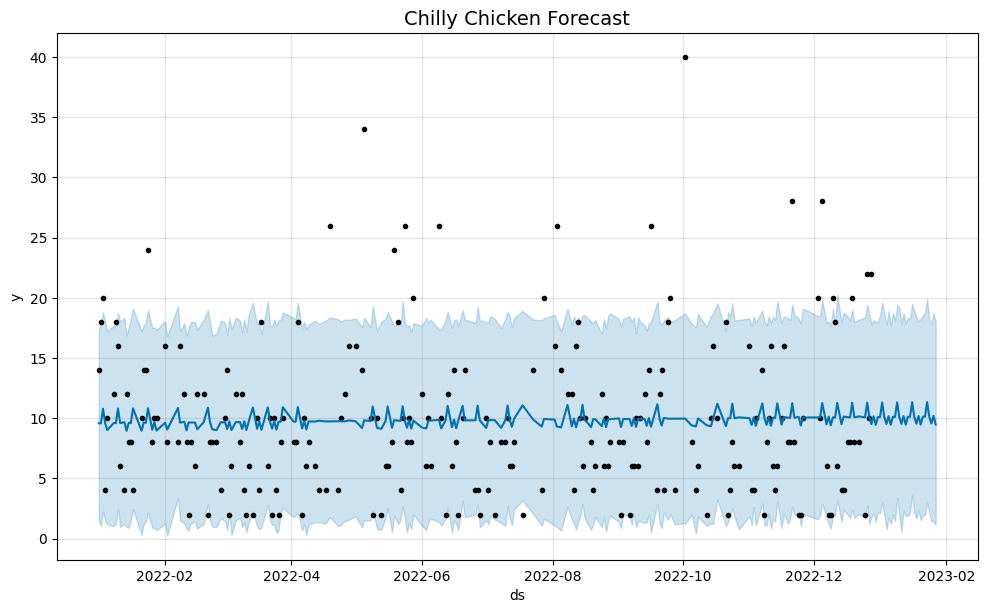

13:12:07 - cmdstanpy - INFO - Chain [1] start processing



📈 Forecasting for: Masala Dosa


13:12:07 - cmdstanpy - INFO - Chain [1] done processing


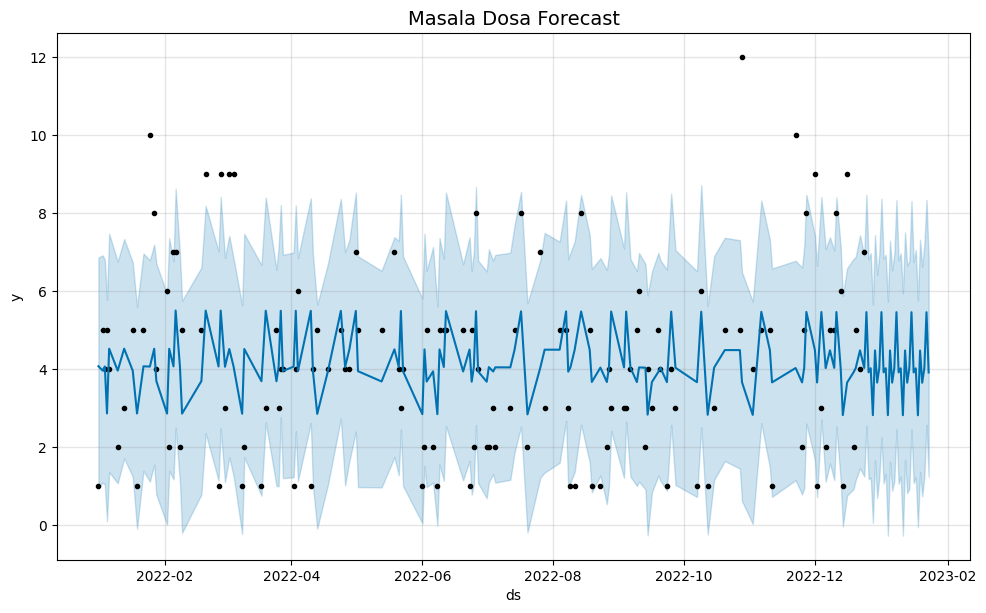


📈 Forecasting for: Gobi Manchurian


13:12:08 - cmdstanpy - INFO - Chain [1] start processing
13:12:08 - cmdstanpy - INFO - Chain [1] done processing


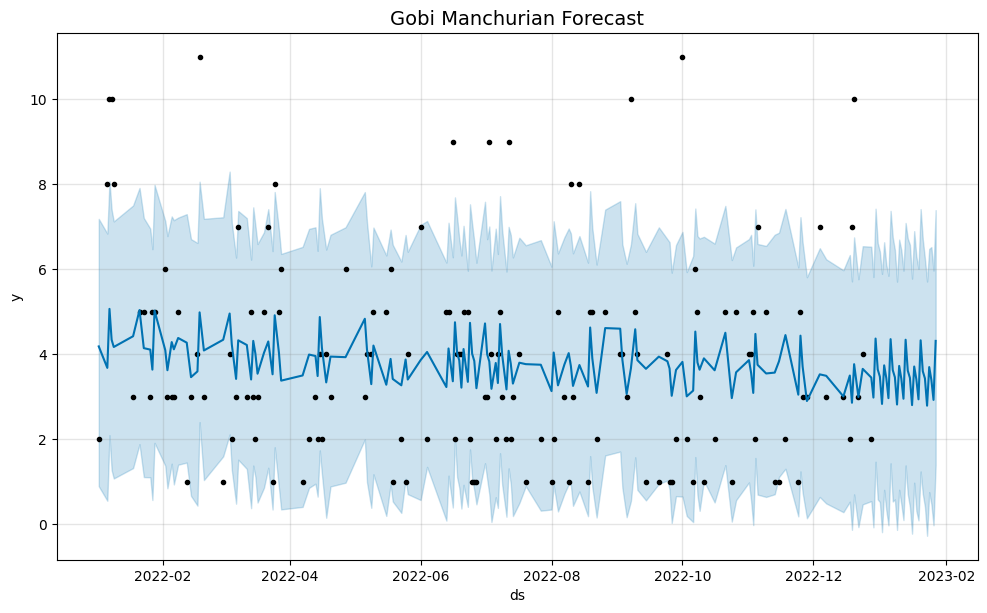


📈 Forecasting for: Paneer Butter Masala


13:12:09 - cmdstanpy - INFO - Chain [1] start processing
13:12:09 - cmdstanpy - INFO - Chain [1] done processing


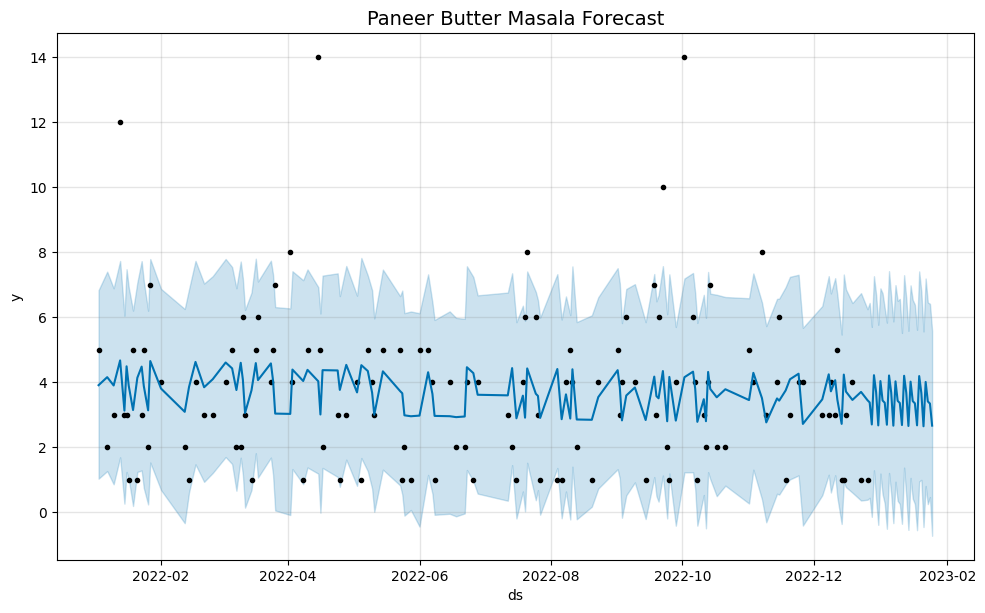


📈 Forecasting for: Chicken Fried Rice


13:12:10 - cmdstanpy - INFO - Chain [1] start processing
13:12:10 - cmdstanpy - INFO - Chain [1] done processing


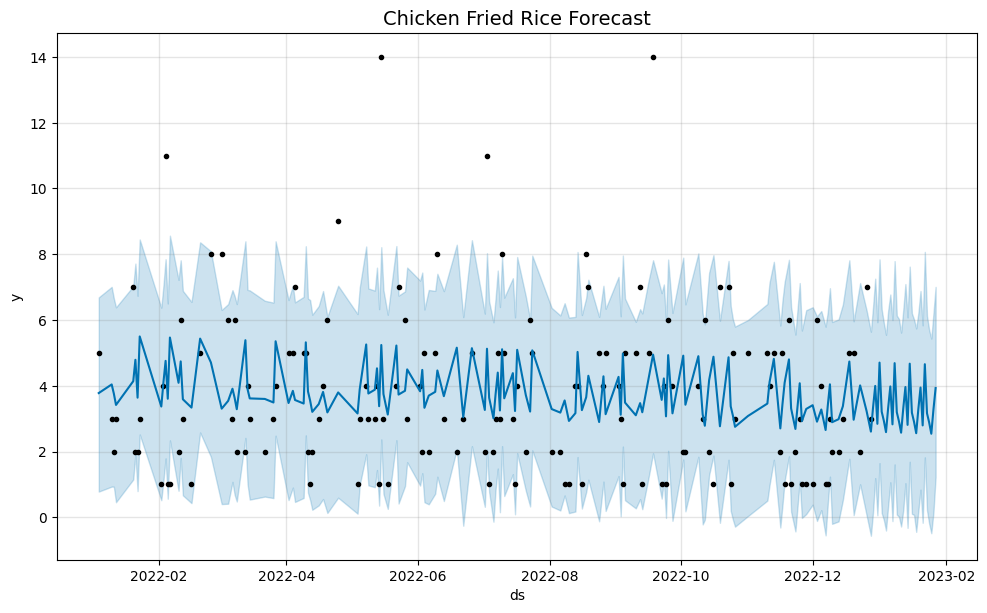

In [367]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Unique dish list
dish_list = df_grouped['Dish_Name'].unique()

# Forecast results will be stored here
all_forecasts = {}
summary = []  # 🆕 For average forecast table

# Loop through each dish
for dish in dish_list:
    print(f"\n📈 Forecasting for: {dish}")
    
    # Filter data for this dish
    df_dish = df_grouped[df_grouped['Dish_Name'] == dish].copy()
    df_dish = df_dish.rename(columns={'Order_Date': 'ds', 'Quantity_Ordered': 'y'})
    
    # Sort values
    df_dish = df_dish.sort_values('ds')
    
    # Prophet model
    model = Prophet()
    model.fit(df_dish)
    
    # Make future df (30 days)
    future = model.make_future_dataframe(periods=30)
    
    # Predict
    forecast = model.predict(future)
    
    # Store forecast
    all_forecasts[dish] = forecast

    # ---------------------------- #
    # 📊 Summary Info Calculation #
    # ---------------------------- #
    future_forecast = forecast[forecast['ds'] > df_dish['ds'].max()]
    avg_qty = future_forecast['yhat'].mean()
    lower = future_forecast['yhat_lower'].mean()
    upper = future_forecast['yhat_upper'].mean()
    
    summary.append({
        'Dish': dish,
        'Avg_Predicted_Qty': round(avg_qty),
        'Lower_Bound': round(lower),
        'Upper_Bound': round(upper)
    })

    # Optional: Show plot
    fig = model.plot(forecast)
    plt.title(f"{dish} Forecast", fontsize=14)
    plt.show()

# ---------------------------- #
# ✅ Create Summary Table
# ---------------------------- #
forecast_summary_df = pd.DataFrame(summary)
forecast_summary_df = forecast_summary_df.sort_values(by='Avg_Predicted_Qty', ascending=False)




In [369]:
print("\n🔮 Forecast Summary Table (Top 10 Dishes):\n")
forecast_summary_df.head()


🔮 Forecast Summary Table (Top 10 Dishes):



,Dish,Avg_Predicted_Qty,Lower_Bound,Upper_Bound
1,Chilly Chicken,10,2,19
2,Masala Dosa,4,1,7
0,Chicken Biryani,3,1,6
3,Gobi Manchurian,3,1,6
4,Paneer Butter Masala,3,0,6


In [371]:
print(forecast_summary_df.columns)


Index(['Dish', 'Avg_Predicted_Qty', 'Lower_Bound', 'Upper_Bound'], dtype='object')


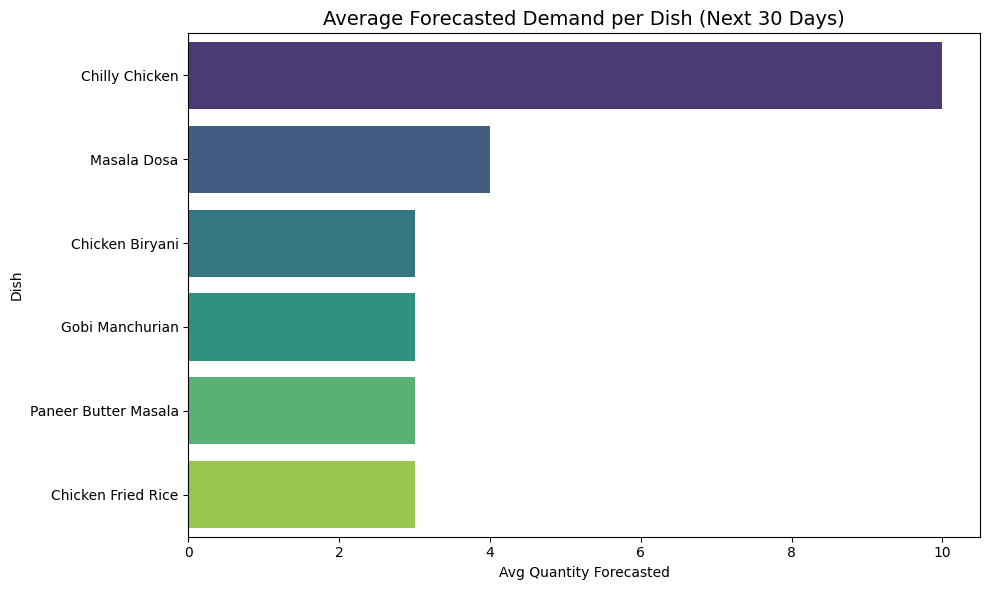

In [373]:
import seaborn as sns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=forecast_summary_df, x='Avg_Predicted_Qty', y='Dish', palette='viridis')

plt.title('Average Forecasted Demand per Dish (Next 30 Days)', fontsize=14)
plt.xlabel('Avg Quantity Forecasted')
plt.ylabel('Dish')
plt.tight_layout()
plt.show()


###  Forecast Summary Insights

1. **Chilly Chicken** shows the **highest average forecasted demand** (10 orders/day) with a wide uncertainty range (2 to 18), suggesting it's both popular and volatile.
2. **Masala Dosa** has moderate and consistent demand (avg: 4), with lower uncertainty—this could be a reliable menu item.
3. **Chicken Biryani, Gobi Manchurian, and Paneer Butter Masala** show **lower predicted demand** (avg: 3 or less) and are relatively stable.


### Recommendations

-  **Prepare more Chilly Chicken daily** (up to 18 orders) to meet high demand and avoid stockouts.
-  **Keep Masala Dosa in consistent stock** — steady performer with predictable demand.
-  **Monitor low-demand dishes** (e.g., Biryani, Gobi Manchurian) — consider removing or bundling with offers.


In [ ]:
# forecast_summary_df.to_csv("forecast_summary.csv", index=False)
